In [42]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from lmfit.models import GaussianModel

from scipy import optimize as optim

import sys
sys.path.append('../Library')

import image_analysis as ia # module with most of the code
import drop_detection_tools as ddt

from importlib import reload

import uncertainties as unc
import uplotlib as uplt


plot_dir = '../../../Report/Plots/i/'
plot_dir.rstrip('/')


# reload(plt)
%matplotlib notebook

In [2]:
FontSize = 18
plt.rc('axes',   titlesize = FontSize) # fontsize of the axes title
plt.rc('axes',   labelsize = FontSize) # fontsize of the x and y labels
plt.rc('xtick',  labelsize = FontSize) # fontsize of the tick labels
plt.rc('ytick',  labelsize = FontSize) # fontsize of the tick labels
plt.rc('legend', fontsize  = FontSize) # legend fontsize
plt.rc('figure', titlesize = FontSize) # fontsize of the figure title

matplotlib.rcParams.update({
    'font.family': 'serif',
    'font.size' : 17.28,
    'text.usetex': True,
    'pgf.rcfonts': False,
})

## Extract frames from video

This needs to be done only once for every video

In [3]:
path = '../../../T-data/2-12/'
video_name = 'B-ol3-aq7-spf1.wmv'

folder = ia.extract_frames(path, video_name)

Frames already extracted :)


## Get arrays from video

In [4]:
pars = video_name.rsplit('.', 1)[0].split('-')
chip_name = pars[0]
liq1 = pars[1][:2]
flux1 = float(pars[1][2:])
liq2 = pars[2][:2]
flux2 = float(pars[2][2:])
spf = float(pars[3][3:])

print(f'chip {chip_name}:\n  {liq1}: {flux1}\n  {liq2}: {flux2}\n  spf: {spf}\n')

name = path.rstrip('/').rsplit('/',1)[1] + '_' + video_name.rsplit('-',1)[0] + '_i'

print(f'{name = }\n')

radius  = 0.3  # capillary radius [mm]
A  = np.pi*0.25*radius**2       # capillary area [mm2]
v  = (flux1 + flux2)/A/60   # drops speed [mm/s]

print(f'Expected drop speed {v = :.3f} mm/s')

chip B:
  ol: 3.0
  aq: 7.0
  spf: 1.0

name = '2-12_B-ol3-aq7_i'

Expected drop speed v = 2.358 mm/s


In [5]:
color = 1 # green

arrays, mean_array = ia.get_arrays(folder,color,max_frames=1000)

print(arrays.shape)

Image.fromarray(mean_array).show()

Last frame analyzed: 600
(600, 960, 1280)


## Subtract the mean

In [6]:
arrays_sub = ia.subtract_mean(arrays,mean_array, negative=True, verbose=True)

batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
m = -76.0, M = 69.0
converting to np.uint8
making the negative
concatenating

DONE! (Phew that was a huge array, you are a kernel serial killer)


In [7]:
# see an example

idx = 214

Image.fromarray(arrays[idx]).show()
Image.fromarray(arrays_sub[idx]).show()

# Image.fromarray(arrays[idx]).save(f'{plot_dir}/gray.png')
# Image.fromarray(arrays_sub[idx]).save(f'{plot_dir}/neg.png')

In [8]:
# optional

# see the corresponding negative image

neg = 255 - arrays_sub[idx]
Image.fromarray(neg).show()

# Image.fromarray(neg).save(f'{plot_dir}/sub.png')

## Rotation and gaussian filter

In [8]:
# test on one image

rotation = 19
filter_size = 0 # y and x sigmas for the filter

img = ia.preprocess(arrays_sub[idx], rotation=rotation, filter_size=filter_size)
img.show()

# img.save(f'{plot_dir}/rot.png')

In [9]:
# apply to all images
imgs = []
for array_sub in tqdm(arrays_sub):
    imgs.append(ia.preprocess(array_sub, rotation=rotation, filter_size=filter_size))

imgs = np.array(imgs,dtype=Image.Image)
# calibration image
calibr_img = ia.preprocess(arrays[idx], rotation=rotation, filter_size=0) # keep the image sharp

calibr_img.show()

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:08<00:00, 71.05it/s]


## Channel analyzer

### Calibrate

In [10]:
c = ia.Channel_analyzer()

<IPython.core.display.Javascript object>


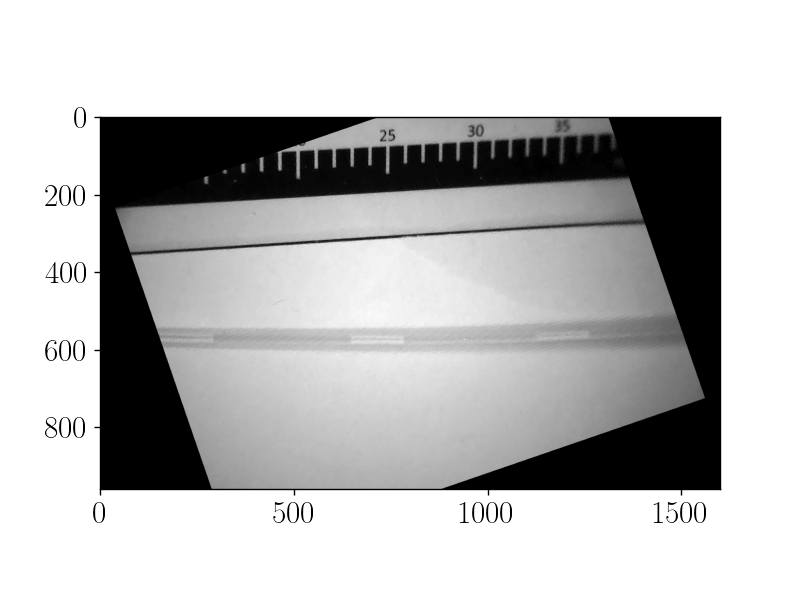

In [11]:
# optional if object is already calibrated
fig = c.calibrate(calibr_img,15, cmap='gist_gray')

In [ ]:
# fig.savefig(f'{plot_dir}/channel.png')

In [ ]:
# optional if object is already calibrated
fig = c.find_channel(calibr_img, cmap='gist_gray')

<IPython.core.display.Javascript object>


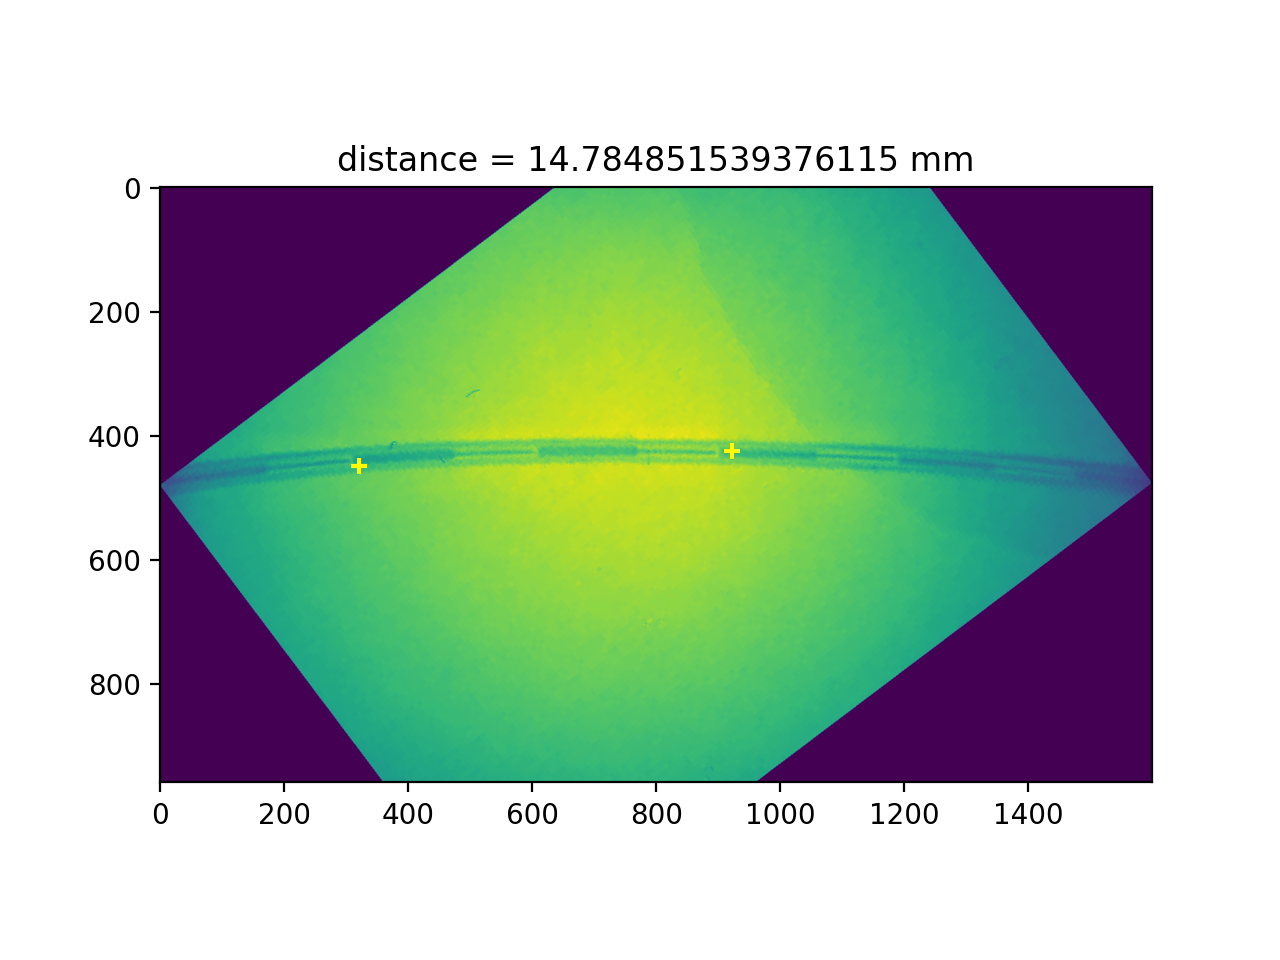

In [9]:
# optional
c.measure_distance(calibr_img)

### Save calibration

In [13]:
c.save(name='calibr_B-ol3-aq7',folder='../../../T-data/2-12/')

../../../T-data/2-12/calibr_B-ol3-aq7 exists: overwrite? [y/n]n


### Load from existing calibration

In [12]:
c.load(name='calibr_B-ol3-aq7',folder='../../../T-data/2-12')

## Waveform extraction

### Try waveform extraction on one image

<IPython.core.display.Javascript object>


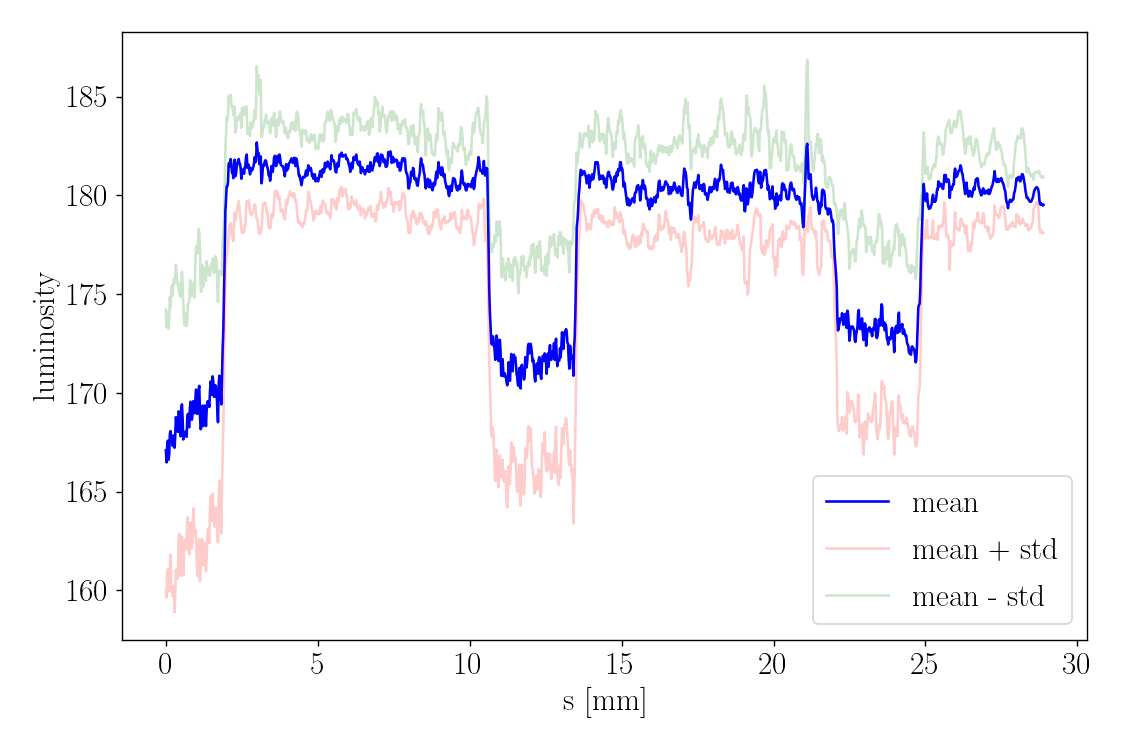

In [16]:
idx = 62

img = imgs[idx]
s, mean, std = c.evaluate(img)

fig,ax = plt.subplots(figsize=(9,6))
plt.plot(s,mean, color='blue', label='mean')
plt.plot(s,mean - std,color='red',alpha=0.2, label='mean + std')
plt.plot(s,mean + std,color='green',alpha=0.2, label = 'mean - std')

plt.xlabel('s [mm]')
plt.ylabel('luminosity')

plt.legend()

fig.tight_layout()

# fig.savefig(f'{plot_dir}/wf_extraction.png')

<IPython.core.display.Javascript object>


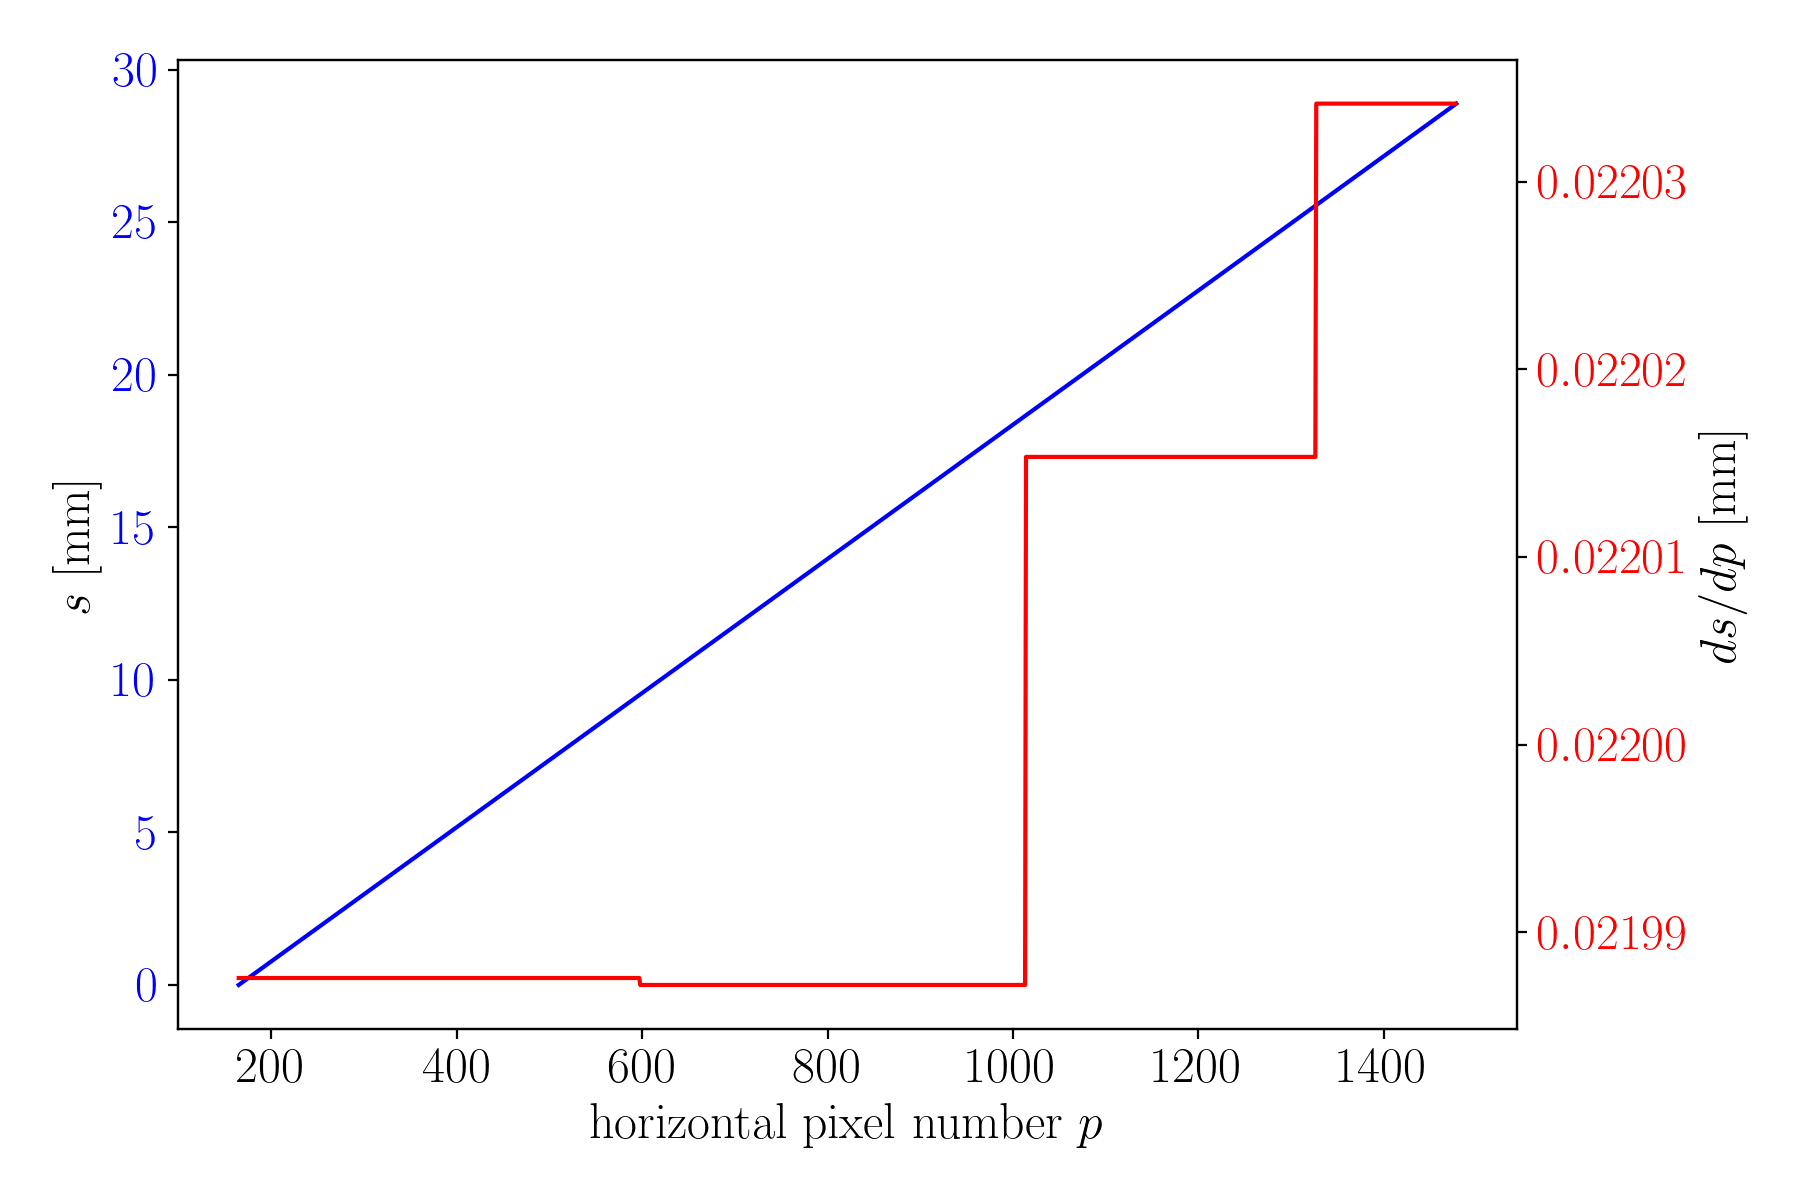

In [34]:
# optional

fig,ax1 = plt.subplots(figsize=(9,6))

ax1.plot(np.arange(c.points[0][0], c.points[-1][0] + 1), s, color='blue')
ax1.set_ylabel('$s$ [mm]')
ax1.tick_params(axis = 'y', labelcolor='blue')
ax1.set_xlabel('horizontal pixel number $p$')

ax2 = ax1.twinx()

ax2.plot(np.arange(c.points[0][0], c.points[-1][0]), s[1:] - s[:-1], color='red')
ax2.set_ylabel('$ds/dp$ [mm]')
ax2.tick_params(axis = 'y', labelcolor='red')

fig.tight_layout()


# fig.savefig(f'{plot_dir}/s_vs_p')

### Improving the waveform

### Rectify

100%|████████████████████████████████████████████████████████████████████████████| 1314/1314 [00:00<00:00, 6130.34it/s]


<IPython.core.display.Javascript object>


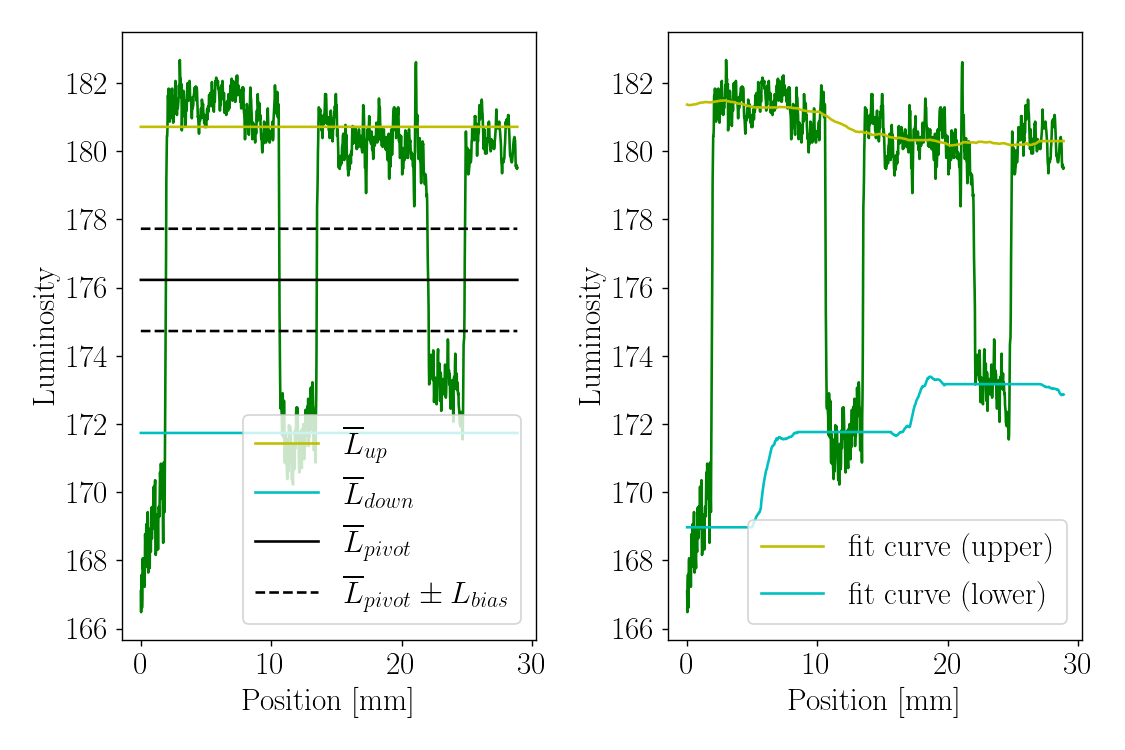

<IPython.core.display.Javascript object>


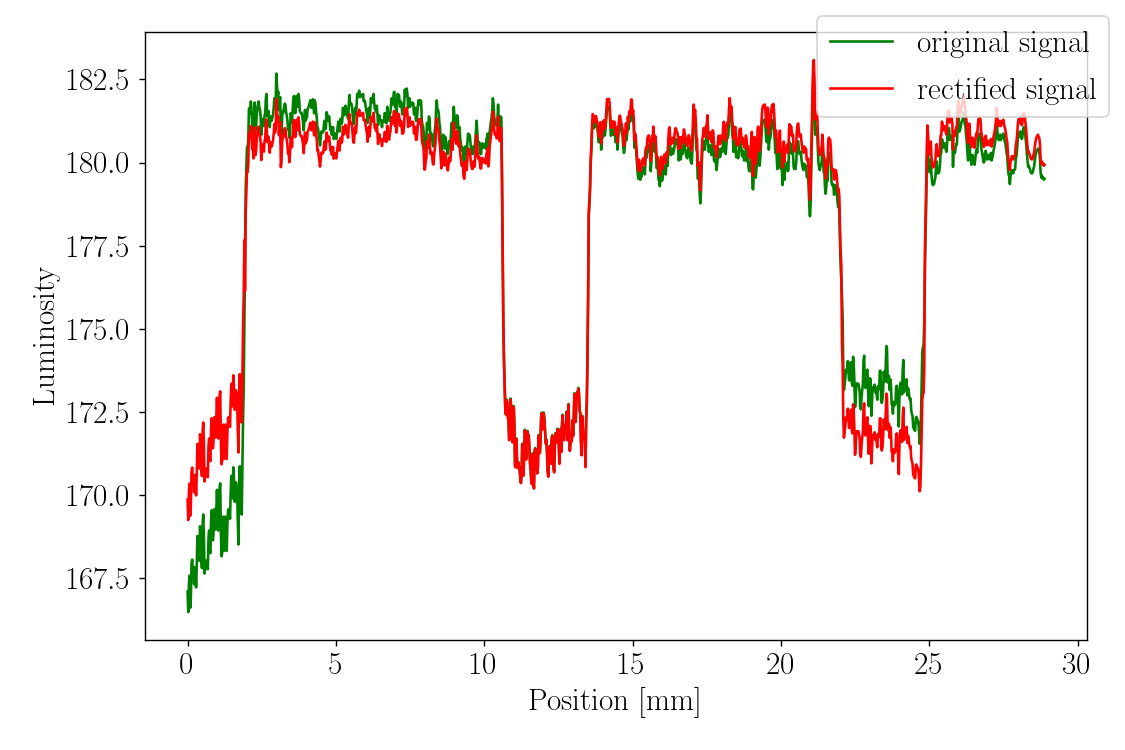

In [17]:
# try on one image

xrange = 5
ignore_bias = 1.5

figs, r_sig = ddt.rectify_new(mean,xdata=s, xrange=xrange, ignore_bias=ignore_bias,
                              xlabel='Position [mm]', ylabel='Luminosity', figsize=(9,6))

# figs[0].savefig(f'{plot_dir}/wf_rectification1.png')
# figs[1].savefig(f'{plot_dir}/wf_rectification2.png')

### Extract all waveforms

In [18]:
s     = 0.
means = []
stds  = []

for idx in tqdm(range(len(imgs))):
    s, mean, std = c.evaluate(imgs[idx])
    means.append(mean)
#     stds.append(std) # not used actually so no need to save it 

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [01:13<00:00,  8.14it/s]


### Rectify the waveforms

In [19]:
means = [ddt.rectify_new(mean, xdata=s, xrange=xrange,ignore_bias=ignore_bias,
                         plot_switch=False, prog_bar=False)[1] for mean in tqdm(means)]

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [01:49<00:00,  5.50it/s]


## Thresholds searching 

<IPython.core.display.Javascript object>


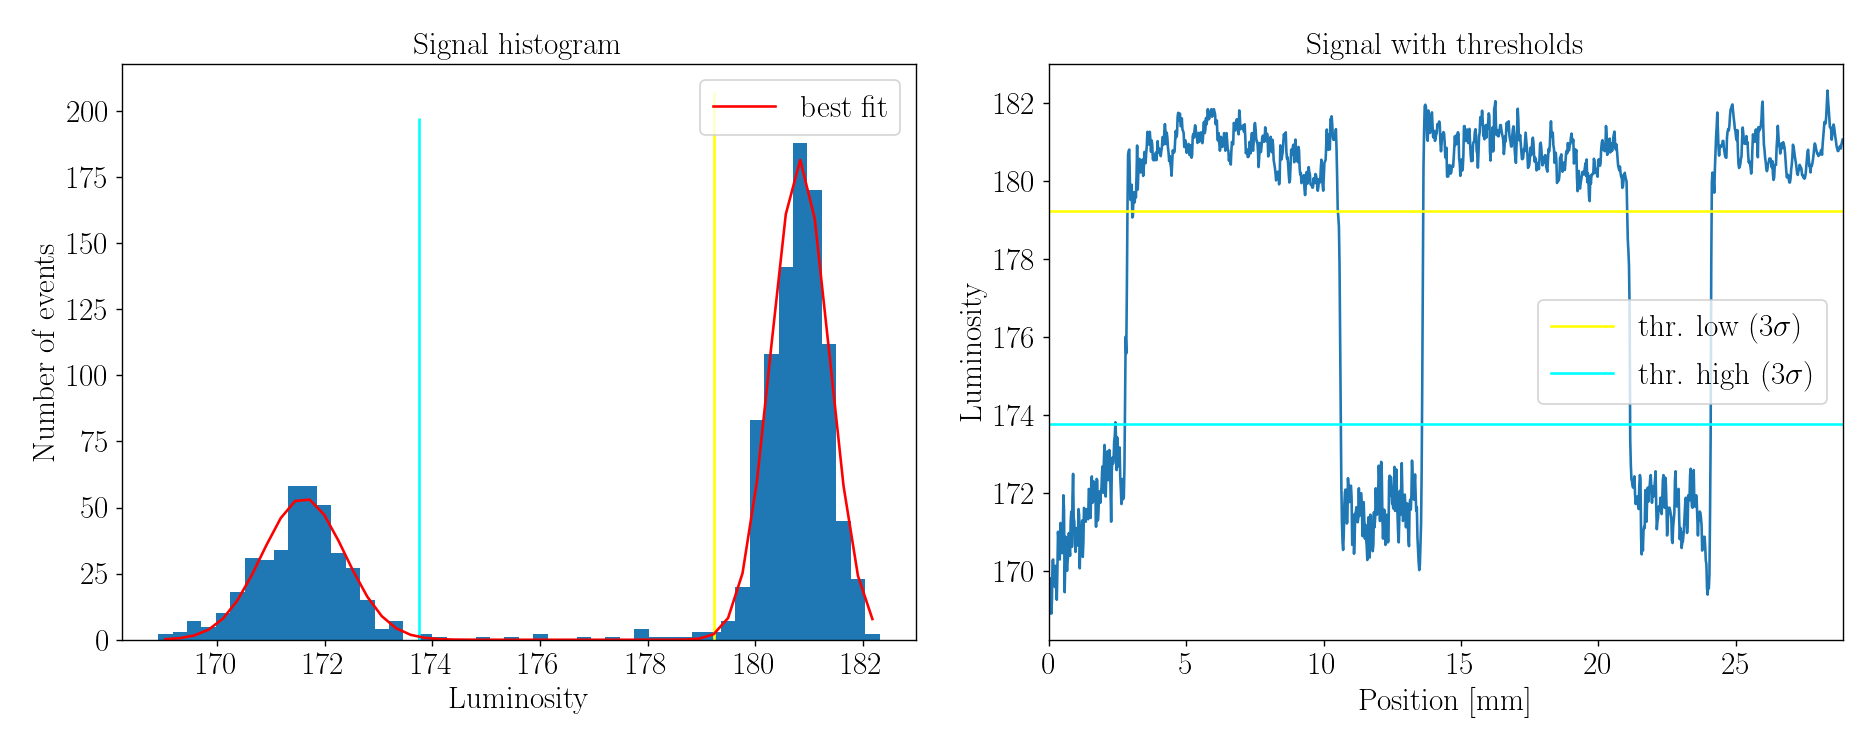

In [20]:
# Try on one image

#**************************************************
idx         = 214     # Frame index (checking plots)
nbins       = 50    # Histo bins number
plot_switch = True  # Plots activation

high_sigmas = 3
low_sigmas = 3

# Not needed
# ymin      = 120   # Plot min. luminosity
# ymax      = 130   # Plot max. luminosity
#**************************************************

%matplotlib notebook

# Plot one single signal (checking)
returns = ddt.thr_searcher(Ydata=means[idx], nbins=nbins, plot_switch=plot_switch, Xdata=s,
                            high_sigmas=high_sigmas, low_sigmas=low_sigmas)

### Compute the thresholds using all data at once

<IPython.core.display.Javascript object>


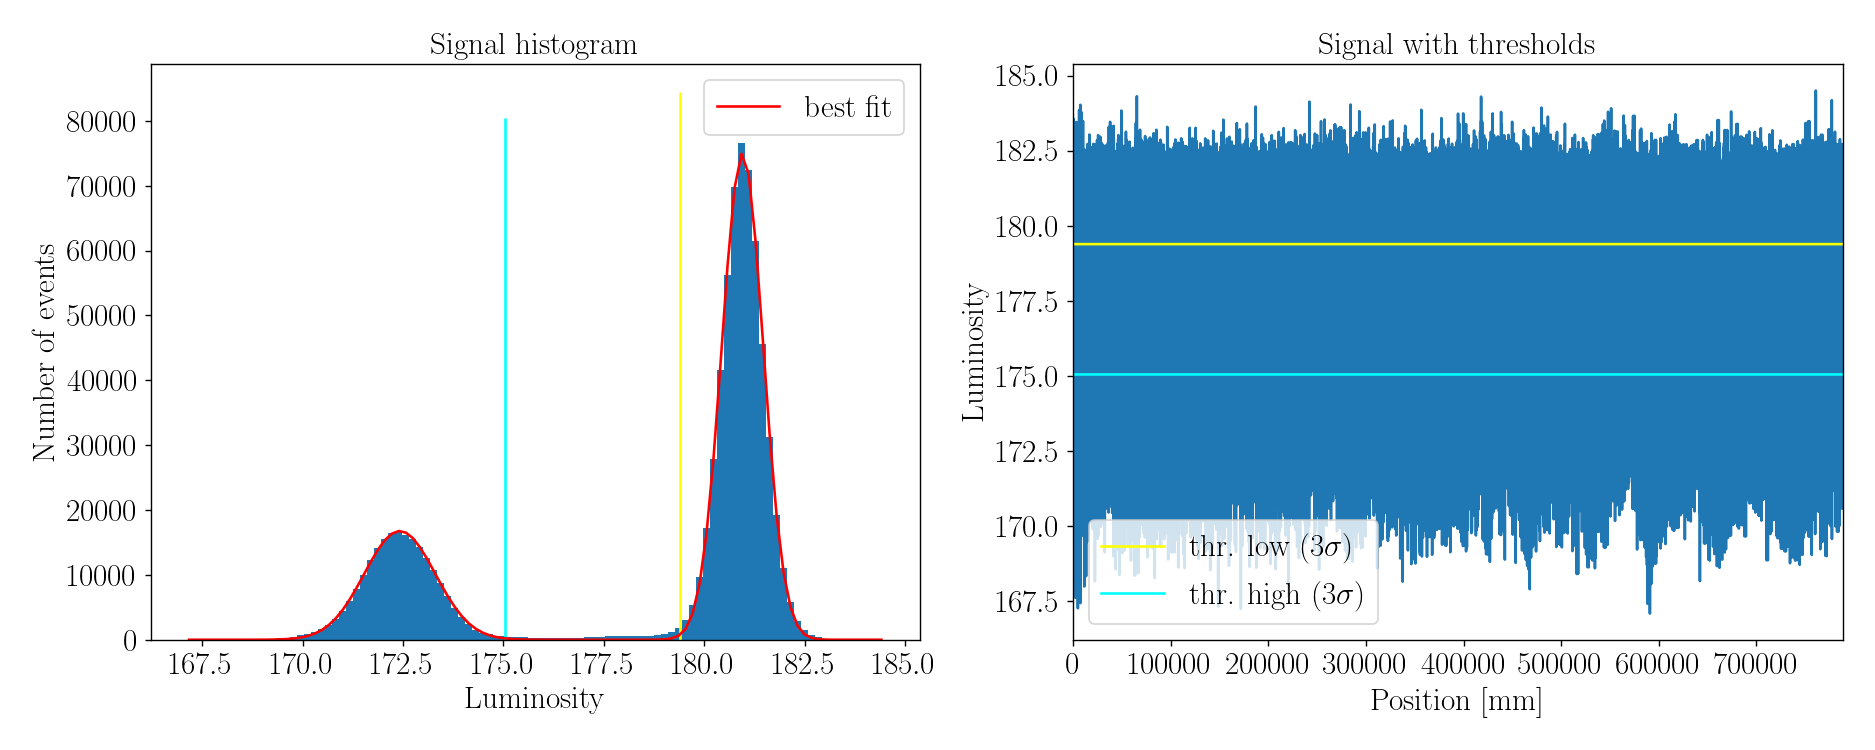

../Library\drop_detection_tools.py:427: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()


In [21]:
nbins       = 100    # Histo bins number
plot_switch = True  # Plots activation

high_sigmas = 3
low_sigmas = 3

c01 = None
c02 = None

returns = ddt.thr_searcher(Ydata=np.concatenate(means), nbins=nbins, plot_switch=plot_switch,
                           high_sigmas=high_sigmas, low_sigmas=low_sigmas,c01=c01,c02=c02)

thr_low, thr_high, sigma_low, sigma_high = returns

## Drop detection 

In [22]:
# manual setting of thrs: deprecated

o = input('Are you sure you want to override thresholds? [y/n] ')

if o == 'y':
    thr_low = 177.5
    thr_low = 176

Are you sure you want to override thresholds? [y/n] n


2 2
2 2


<IPython.core.display.Javascript object>


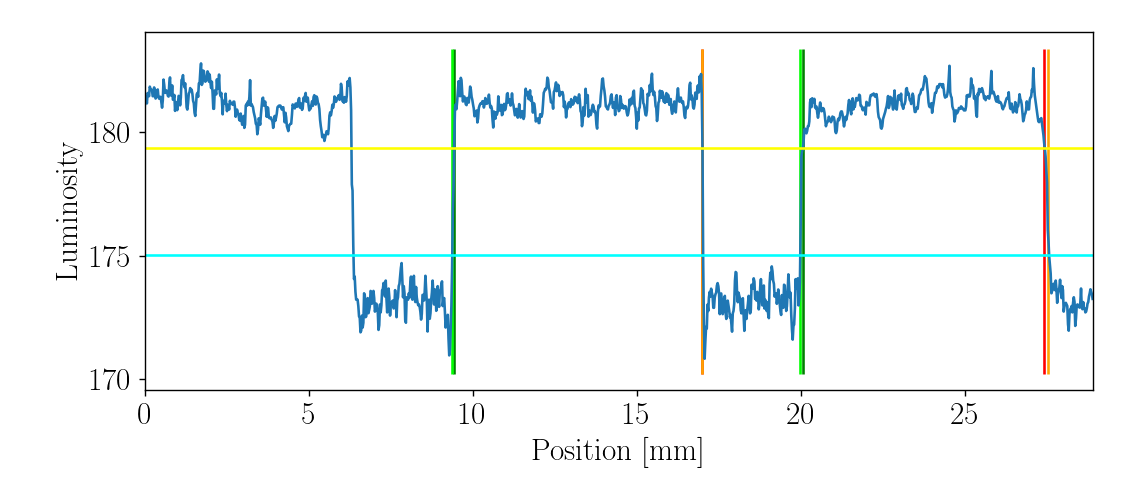

(array([ 9.41067682, 20.05425211]),
 array([16.99625988, 27.4089527 ]),
 array([ 9.36670169, 19.9661908 ]),
 array([16.99625988, 27.5411576 ]))

In [47]:
# Detection of the edges of the drops

idx = 202# Frame index (checking plot)


returns = ddt.drop_det_new(Xdata=s, Ydata=means[idx], thr_low=thr_low, thr_high=thr_high,
                           backward_skip=0, forward_skip=0, return_indexes=False, keep_invalid=False,
                           figsize=(9,4), xlabel='Position [mm]', ylabel= 'Luminosity')

# narrow_start, narrow_end, wide_start, wide_end = returns

returns

### Compute starts and ends for every frame

In [44]:
drop_edges = [] # will be as indices
has_error = False

for i,mean in enumerate(means):
    print(f'\nframe {i}:')
    returns = ddt.drop_det_new(Xdata=s, Ydata=mean, thr_low=thr_low, thr_high=thr_high,
                               backward_skip=0, forward_skip=0,
                               plot_switch=False, return_indexes=True, keep_invalid=False)
    narrow_start, narrow_end, wide_start, wide_end = returns
    
    drop_edges.append([wide_start, narrow_start, narrow_end, wide_end])


frame 0:
4 4
3 3

frame 1:
3 3
3 3

frame 2:
3 3
3 3

frame 3:
3 3
2 2

frame 4:
3 3
3 3

frame 5:
4 4
3 3

frame 6:
2 2
2 2

frame 7:
2 2
2 2

frame 8:
2 2
2 2

frame 9:
3 3
3 3

frame 10:
2 2
2 2

frame 11:
2 2
2 2

frame 12:
2 2
2 2

frame 13:
2 2
2 2

frame 14:
2 2
2 2

frame 15:
2 2
2 2

frame 16:
3 3
2 2

frame 17:
2 2
2 2

frame 18:
2 2
1 1

frame 19:
2 2
2 2

frame 20:
2 2
2 2

frame 21:
2 2
2 2

frame 22:
2 2
2 2

frame 23:
2 2
2 2

frame 24:
2 2
2 2

frame 25:
2 2
1 1

frame 26:
3 3
2 2

frame 27:
2 2
2 2

frame 28:
2 2
2 2

frame 29:
2 2
2 2

frame 30:
1 1
1 1

frame 31:
2 2
2 2

frame 32:
2 2
2 2

frame 33:
3 3
2 2

frame 34:
2 2
2 2

frame 35:
2 2
1 1

frame 36:
3 3
2 2

frame 37:
2 2
2 2

frame 38:
2 2
2 2

frame 39:
1 1
1 1

frame 40:
2 2
2 2

frame 41:
2 2
2 2

frame 42:
2 2
2 2

frame 43:
3 3
2 2

frame 44:
2 2
2 2

frame 45:
3 3
2 2

frame 46:
2 2
2 2

frame 47:
2 2
2 2

frame 48:
2 2
2 2

frame 49:
2 2
2 2

frame 50:
2 2
1 1

frame 51:
2 2
2 2

frame 52:
2 2
2 2

fr

2 2
2 2

frame 419:
2 2
2 2

frame 420:
2 2
2 2

frame 421:
2 2
2 2

frame 422:
2 2
2 2

frame 423:
2 2
2 2

frame 424:
2 2
2 2

frame 425:
2 2
2 2

frame 426:
2 2
2 2

frame 427:
2 2
2 2

frame 428:
2 2
2 2

frame 429:
2 2
2 2

frame 430:
2 2
2 2

frame 431:
2 2
2 2

frame 432:
2 2
2 2

frame 433:
2 2
2 2

frame 434:
2 2
2 2

frame 435:
2 2
2 2

frame 436:
2 2
2 2

frame 437:
2 2
2 2

frame 438:
2 2
2 2

frame 439:
2 2
2 2

frame 440:
3 3
2 2

frame 441:
3 3
2 2

frame 442:
2 2
2 2

frame 443:
2 2
2 2

frame 444:
2 2
2 2

frame 445:
3 3
2 2

frame 446:
2 2
2 2

frame 447:
2 2
2 2

frame 448:
2 2
2 2

frame 449:
2 2
2 2

frame 450:
3 3
2 2

frame 451:
2 2
2 2

frame 452:
2 2
2 2

frame 453:
2 2
2 2

frame 454:
2 2
2 2

frame 455:
2 2
2 2

frame 456:
2 2
2 2

frame 457:
2 2
2 2

frame 458:
2 2
2 2

frame 459:
2 2
2 2

frame 460:
2 2
2 2

frame 461:
2 2
2 2

frame 462:
2 2
2 2

frame 463:
2 2
2 2

frame 464:
2 2
2 2

frame 465:
2 2
2 2

frame 466:
2 2
2 2

frame 467:
2 2
2 2

frame 468:


In [46]:
drop_edges[202]

[array([426, 908]),
 array([428, 912]),
 array([ 773, 1246]),
 array([ 773, 1252])]

In [43]:
reload(ddt)

<module 'drop_detection_tools' from '../Library\\drop_detection_tools.py'>

### Remove small drops

In [25]:
def remove_small_drops(drop_edges, min_size, wide=True):
    for i, edges in enumerate(drop_edges):
        if wide:
            sizes = edges[-1] - edges[0] # use the wide size
        else:
            sizes = edges[-2] - edges[1] # use the narrow size
        idx_to_remove = []
        for j,si in enumerate(sizes):
            if si < min_size:
                idx_to_remove.append(j)
        if len(idx_to_remove) > 0:
            print(f'removing {len(idx_to_remove)} drops from frame {i}')
            for k in range(len(edges)):
                edges[k] = np.delete(edges[k], idx_to_remove)
    
    return drop_edges

In [26]:
if has_error:
    raise TypeError('Errors already computed: you do not need this cell')

drop_edges = remove_small_drops(drop_edges,min_size=1)

## Add errors

### Evaluate slopes

<IPython.core.display.Javascript object>


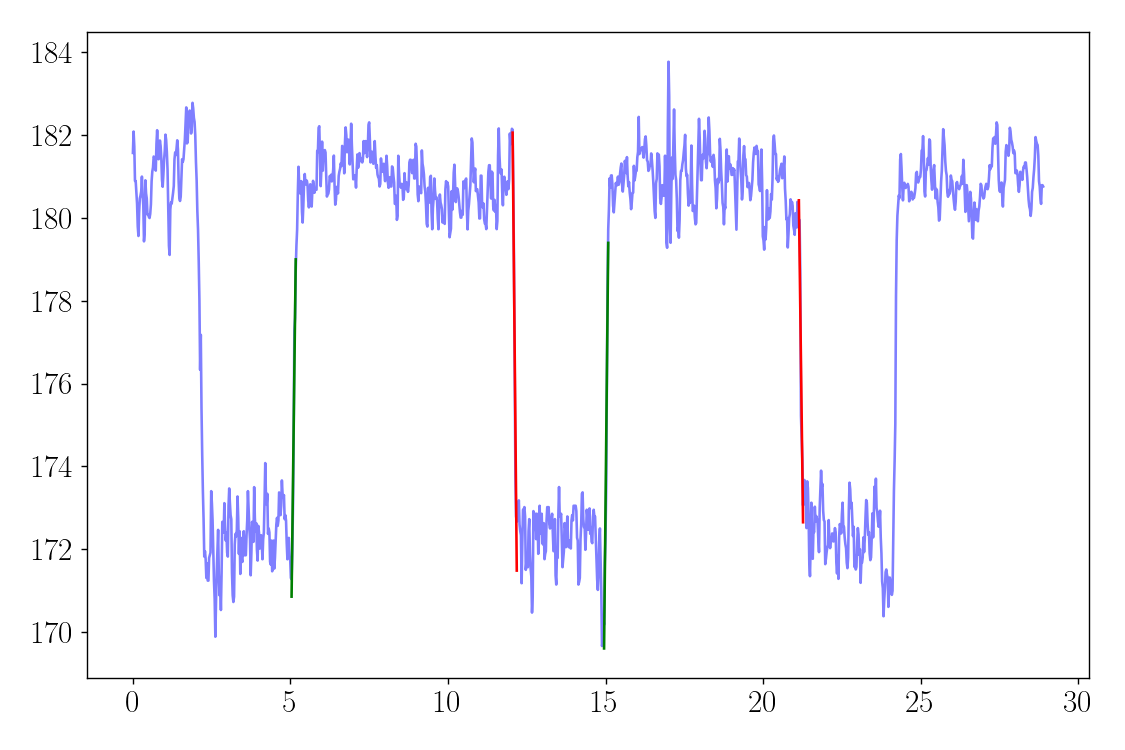

<IPython.core.display.Javascript object>


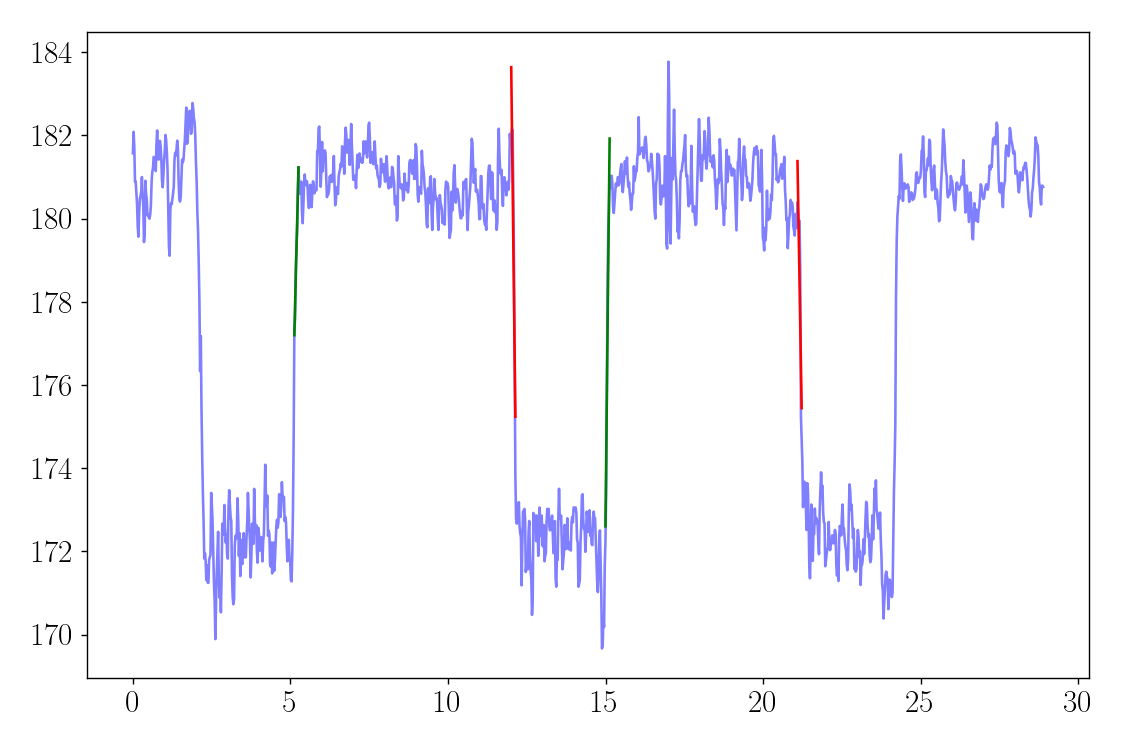

In [48]:
# test on one frame
idx=6

start_range = 3
end_range = 3

if not has_error:
    edges = drop_edges[idx]
else:
    returns = ddt.drop_det_new(Xdata=s, Ydata=means[idx], thr_low=thr_low, thr_high=thr_high,
                               backward_skip=0, forward_skip=0, return_indexes=True, keep_invalid=False,
                               plot_switch=False)
    edges = [returns[2], returns[0], returns[1], returns[3]]

ws_start, ws_end = ddt.slopes(s, means[idx], edges[0], edges[-1], direction='both',
                              start_range=start_range, end_range=end_range, figsize=(9,6))
ns_start, ns_end = ddt.slopes(s, means[idx], edges[1], edges[-2], direction='both',
                              start_range=start_range, end_range=end_range, figsize=(9,6))

In [49]:
ws_start

array([61.72693419, 74.22857282])

In [50]:
# apply to all
if has_error:
    raise TypeError('Errors already computed: you do not need this cell')


slopes = []

for i, edges in enumerate(drop_edges):
    print(f'frame {i}: ',end='')
    ws_start, ws_end = ddt.slopes(s, means[i], edges[0], edges[-1],
                              start_range=start_range, end_range=end_range, plot_switch=False)
    ns_start, ns_end = ddt.slopes(s, means[i], edges[1], edges[-2],
                                  start_range=start_range, end_range=end_range, plot_switch=False)
    
    slopes.append([ws_start, ns_start, ns_end, ws_end])
    print('ok')

frame 0: ok
frame 1: ok
frame 2: ok
frame 3: ok
frame 4: ok
frame 5: ok
frame 6: ok
frame 7: ok
frame 8: ok
frame 9: ok
frame 10: ok
frame 11: ok
frame 12: ok
frame 13: ok
frame 14: ok
frame 15: ok
frame 16: ok
frame 17: ok
frame 18: ok
frame 19: ok
frame 20: ok
frame 21: ok
frame 22: ok
frame 23: ok
frame 24: ok
frame 25: ok
frame 26: ok
frame 27: ok
frame 28: ok
frame 29: ok
frame 30: ok
frame 31: ok
frame 32: ok
frame 33: ok
frame 34: ok
frame 35: ok
frame 36: ok
frame 37: ok
frame 38: ok
frame 39: ok
frame 40: ok
frame 41: ok
frame 42: ok
frame 43: ok
frame 44: ok
frame 45: ok
frame 46: ok
frame 47: ok
frame 48: ok
frame 49: ok
frame 50: ok
frame 51: ok
frame 52: ok
frame 53: ok
frame 54: ok
frame 55: ok
frame 56: ok
frame 57: ok
frame 58: ok
frame 59: ok
frame 60: ok
frame 61: ok
frame 62: ok
frame 63: ok
frame 64: ok
frame 65: ok
frame 66: ok
frame 67: ok
frame 68: ok
frame 69: ok
frame 70: ok
frame 71: ok
frame 72: ok
frame 73: ok
frame 74: ok
frame 75: ok
frame 76: ok
frame 77:

### Make ufloats

In [51]:
def res_error(position):
    a = s[np.where(s >= position)]
    
    return (a[1] - a[0])/np.sqrt(12)
def res_error_idx(index):
    if index < len(s) - 1:
        return (s[index + 1] - s[index])/np.sqrt(12)
    return (s[index] - s[index - 1])/np.sqrt(12)

@np.vectorize
def value(v):
    return v.n

@np.vectorize
def std(v):
    return v.s

@np.vectorize
def ufloatify(m, s):
    return unc.ufloat(m,s)

In [52]:
new_drop_edges = []

if not has_error:
    for i, edges in enumerate(drop_edges):
        print(f'frame {i}: ',end='')
        new_drop_edges.append([])
        for k,e in enumerate(edges):
            new_e = []
            for drop_idx in range(len(e)):
                if k in [0,4]: # wide
                    err_slope = sigma_low/slopes[i][k][drop_idx]
                else: # narrow
                    err_slope = sigma_high/slopes[i][k][drop_idx]

                err = np.sqrt(res_error_idx(e[drop_idx])**2 + err_slope**2)

                new_e.append(unc.ufloat(s[e[drop_idx]], err))

            new_drop_edges[-1].append(new_e)
        new_drop_edges[-1] = np.array(new_drop_edges[-1])

        print('ok')

    # overwrite the previous drop_edges
    drop_edges = new_drop_edges
    has_error = True
    
else:
    print('Errors already computed')

frame 0: ok
frame 1: ok
frame 2: ok
frame 3: ok
frame 4: ok
frame 5: ok
frame 6: ok
frame 7: ok
frame 8: ok
frame 9: ok
frame 10: ok
frame 11: ok
frame 12: ok
frame 13: ok
frame 14: ok
frame 15: ok
frame 16: ok
frame 17: ok
frame 18: ok
frame 19: ok
frame 20: ok
frame 21: ok
frame 22: ok
frame 23: ok
frame 24: ok
frame 25: ok
frame 26: ok
frame 27: ok
frame 28: ok
frame 29: ok
frame 30: ok
frame 31: ok
frame 32: ok
frame 33: ok
frame 34: ok
frame 35: ok
frame 36: ok
frame 37: ok
frame 38: ok
frame 39: ok
frame 40: ok
frame 41: ok
frame 42: ok
frame 43: ok
frame 44: ok
frame 45: ok
frame 46: ok
frame 47: ok
frame 48: ok
frame 49: ok
frame 50: ok
frame 51: ok
frame 52: ok
frame 53: ok
frame 54: ok
frame 55: ok
frame 56: ok
frame 57: ok
frame 58: ok
frame 59: ok
frame 60: ok
frame 61: ok
frame 62: ok
frame 63: ok
frame 64: ok
frame 65: ok
frame 66: ok
frame 67: ok
frame 68: ok
frame 69: ok
frame 70: ok
frame 71: ok
frame 72: ok
frame 73: ok
frame 74: ok
frame 75: ok
frame 76: ok
frame 77:

## Plots

<IPython.core.display.Javascript object>


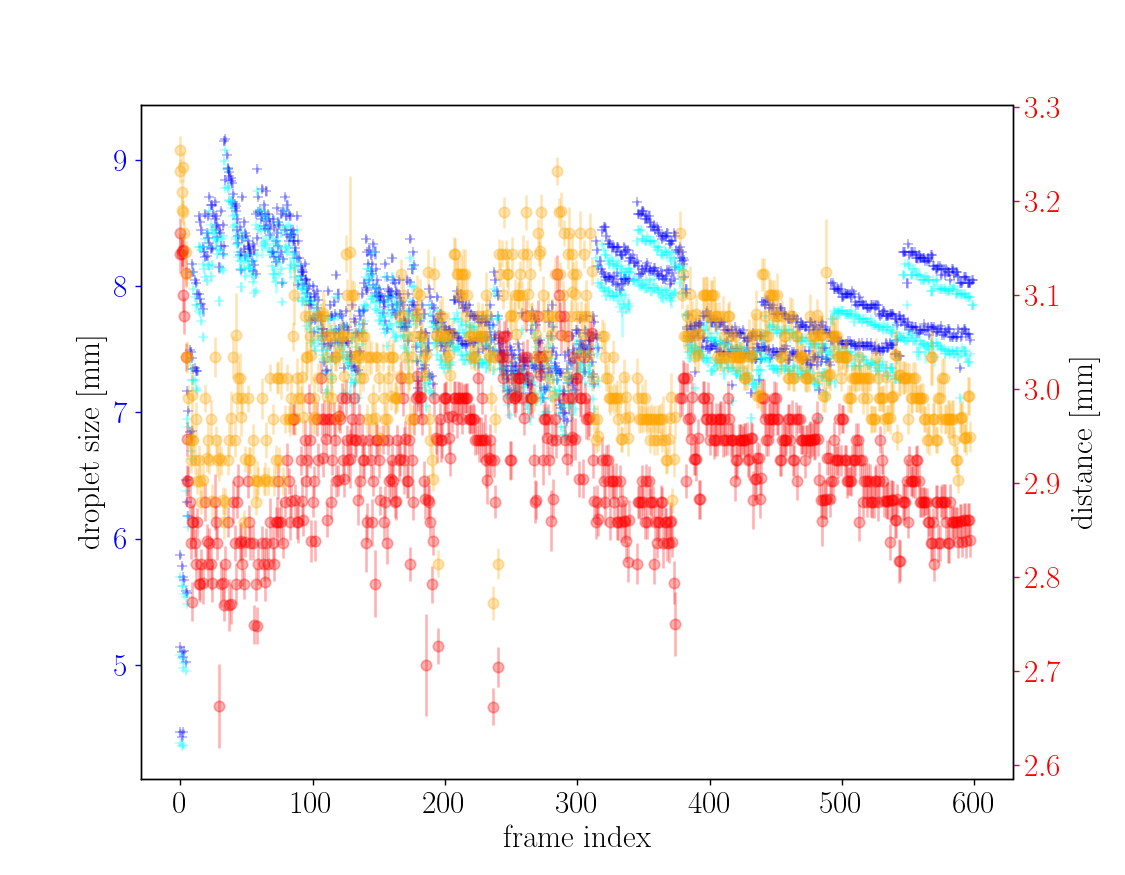

In [53]:
subname = 'size-distance'

wavelenghts = [(i,edges[:,1:] - edges[:,:-1]) for i,edges in enumerate(drop_edges) if len(edges[0]) > 1]

sizes_w = [(i, edges[3] - edges[0]) for i,edges in enumerate(drop_edges) if len(edges[0]) > 0]
sizes_n = [(i, edges[2] - edges[1]) for i,edges in enumerate(drop_edges) if len(edges[0]) > 0]

distances_w = [(i,edges[0,1:] - edges[3,:-1]) for i,edges in enumerate(drop_edges) if len(edges[0]) > 1]
distances_n = [(i,edges[1,1:] - edges[2,:-1]) for i,edges in enumerate(drop_edges) if len(edges[0]) > 1]

fig, ax1 = plt.subplots(figsize=(9,7))
for si in sizes_w:
    uplt.plot([si[0]]*len(si[1]), si[1], ax=ax1, color='blue', fmt='+', alpha=0.3)
for si in sizes_n:
    uplt.plot([si[0]]*len(si[1]), si[1], ax=ax1, color='cyan', fmt='+', alpha=0.3)
ax1.set_xlabel('frame index')
ax1.set_ylabel('droplet size [mm]')
ax1.tick_params(axis='y', colors='blue')
    
ax2 = ax1.twinx()


for si in distances_w:
    uplt.plot([si[0]]*len(si[1]), si[1], ax=ax2, color='red', fmt='o', alpha=0.3)
for si in distances_n:
    uplt.plot([si[0]]*len(si[1]), si[1], ax=ax2, color='orange', fmt='o', alpha=0.3)
ax2.set_ylabel('distance [mm]')


# colors = ['yellow', 'orange', 'red', 'brown']
# for i in range(4):
#     for d in wavelenghts:
#         uplt.plot([d[0]]*len(d[1][0]), d[1][i], ax=ax2, color=colors[i], fmt='o', alpha=0.3)
# ax2.set_ylabel('wavelenght [mm]')


ax2.tick_params(axis='y', colors='red')

ylim1 = ax1.get_ylim()
ylim2 = ax2.get_ylim()

ylim = (min(ylim1[0], ylim2[1]), max(ylim1[1], ylim2[1]))
        
# ax1.set_ylim(*ylim)
# ax2.set_ylim(*ylim)


# fig.savefig(f'{plot_dir}/{name}_{subname}.png')

## Following the droplets along the video

In [54]:
# DO NOT TRANSFER TO .py file !!!! uses local variables

class Droplet():
    def __init__(self,ID):
        self.ID = ID
        self.frames = [] # frame IDs in which the droplet appears
        self.index_in_frame = [] # index of the droplet in every frame in which it appears
        
        self.edges = np.array([])
        
        self._mids = None
        
        self.sizes = None
        self.menisc_sizes = None
        self.velocities = None
        
    def index(self, frame_idx):
        return self.frames.index(frame_idx)
        
    @property
    def recurrence(self):
        return len(self.frames) # number of frames in which the droplet is visible
    
    @property
    def size(self):
        '''
        wide, narrow
        '''
        if self.sizes is None:
            self.sizes = np.array([[(edge[3] - edge[0]), (edge[2] - edge[1])] for edge in self.edges])
        return np.mean(self.sizes, axis=0), np.std(value(self.sizes), axis=0) # cannot compute error on std
    
    @property
    def menisc_size(self):
        '''
        backward, forward
        '''
        if self.menisc_sizes is None:
            self.menisc_sizes = np.array([[(edge[1] - edge[0]), (edge[3] - edge[2])] for edge in self.edges])
        return np.mean(self.menisc_sizes, axis=0), np.std(value(self.menisc_sizes), axis=0) # cannot compute error on std
        
    
    @property
    def mid_positions(self):
        '''
        wide, narrow
        '''
        if self._mids is None:
            self._mids = np.array([[0.5*(edge[0] + edge[3]), 0.5*(edge[1] + edge[2])] for edge in self.edges])
        return self._mids
    
    @property
    def velocity(self):
        '''
        wide, narrow
        '''
        if self.velocities is None:
            if len(self.frames) > 1:
                self.velocities = -(self.mid_positions[1:] - self.mid_positions[:-1])/spf
            else:
                return np.nan, np.nan
        return np.mean(self.velocities, axis=0), np.std(value(self.velocities), axis=0)
    
        
    def add(self, frame_id, idx_in_frame, velocity_range=None, size_perc_tolerance=None):
        '''
        Tries to add a new frame to the droplet. Returns True if it manages to.
        '''
        edge = drop_edges[frame_id][:,idx_in_frame]
        
        if len(self.frames) > 0:
        
            # check if velocity is meaningful
            if velocity_range is not None:
                velocity = (self.edges[-1,1] - edge[1])/spf # compute velocity with narrow start
                if velocity < velocity_range[0]:
                    return False
                if velocity > velocity_range[1]:
                    return False

            # check if size is similar to the previous one
            if size_perc_tolerance is not None:
                old_size = self.edges[-1,2]- self.edges[-1,1] # narrow size
                size = edge[2] - edge[1]
                if np.abs(size - old_size) > old_size*size_perc_tolerance:
                    return False
                
        self.frames.append(frame_id)
        self.index_in_frame.append(idx_in_frame)
        self.edges = np.vstack([*self.edges, edge])
        
        self._mids = None
        self.velocities = None
        self.sizes = None
        self.menisc_sizes = None
        
        return True

In [55]:
print(f'expected velocity is {v:.3f} mm/s')

expected velocity is 2.358 mm/s


100%|██████████████████████████████████████████████████████████████████████████████| 599/599 [00:00<00:00, 2029.03it/s]


<IPython.core.display.Javascript object>


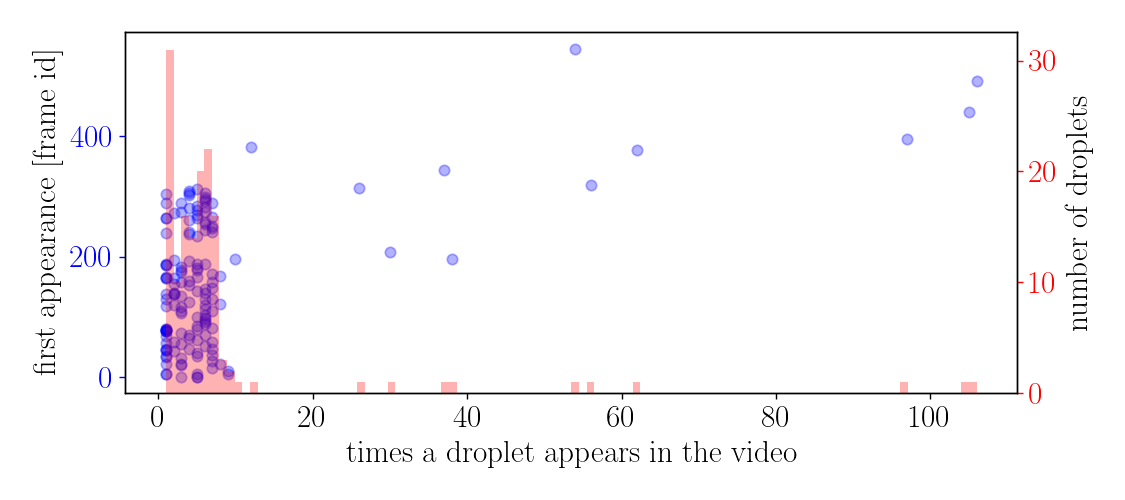

In [57]:
velocity_range = [-0.1, 7]
size_perc_tolerance = 0.5


droplets = []
drop_idx = 0

# create ID mask
ID_mask = []
for edges in drop_edges:
    ID_mask.append([-1]*edges.shape[-1])

# iterate over frame
for idx in tqdm(range(len(drop_edges) - 1)):
    frame_idx = len(drop_edges) - 1 - idx # go reversed
    # iterate over droplets in a frame
    for i,start in enumerate(drop_edges[frame_idx][1]): # cycle on narrow starts
        # detect if droplet is already present
        drop_ID = ID_mask[frame_idx][i]
        if drop_ID == -1: # add new droplet
            ID_mask[frame_idx][i] = drop_ID = drop_idx
            droplets.append(Droplet(drop_idx))
            droplets[drop_idx].add(frame_idx,i)
            drop_idx += 1
        
        # now all droplets in this frame have a valid ID
        # we try to find them in the previous frame (remember we are looking the video in reverse)
        prev_frame_idx = frame_idx - 1
        for prev_i,prev_start in enumerate(drop_edges[prev_frame_idx][1]):
            if ID_mask[prev_frame_idx][prev_i] != -1: # droplet already assigned
                continue
            if droplets[drop_ID].add(prev_frame_idx,prev_i,
                                     velocity_range=velocity_range,
                                     size_perc_tolerance=size_perc_tolerance):
                ID_mask[prev_frame_idx][prev_i] = drop_ID # assign droplet
                break
                
droplets = np.array(droplets,dtype=Droplet)
                
def drops_in_frame(frame_idx):
    drop_ids = ID_mask[frame_idx]
    ddt.drop_det_new(Xdata=s, Ydata=means[frame_idx], backward_skip=0, forward_skip=0,
                     thr_low=thr_low, thr_high=thr_high, plot_switch=True, keep_invalid=False,
                     figsize=(9,2))
    
    for drop in droplets[drop_ids]:
        i = drop.frames.index(frame_idx)
        i_drop = drop.index(frame_idx)
        x = value(drop.mid_positions[i_drop][1]) # use narrow mid position
        y = 0.5*(thr_high + thr_low)
        plt.scatter(x,y,color='black',marker='^')
        plt.text(x,y + 0.25,drop.ID, horizontalalignment='center')
                
    return drop_ids


recurrencies = [d.recurrence for d in droplets]
first_appearances = [d.frames[-1] for d in droplets]

# compute size and velocities
for d in droplets:
    _ = d.velocity
    _ = d.size
    _ = d.menisc_size

subname = 'recurrencies'    

fig, ax1 = plt.subplots(figsize=(9,4))
ax1.scatter(recurrencies, first_appearances, color='blue', alpha=0.3)
ax1.set_xlabel('times a droplet appears in the video')
ax1.set_ylabel('first appearance [frame id]')
ax1.tick_params(axis='y', colors='blue')

ax2 = ax1.twinx()




ax2.hist(recurrencies, bins=max(recurrencies), color='red', alpha=0.3)
ax2.set_ylabel('number of droplets')
ax2.tick_params(axis='y', colors='red')

fig.tight_layout()

# fig.savefig(f'{plot_dir}/{name}_{subname}.png')

4 4
3 3


<IPython.core.display.Javascript object>


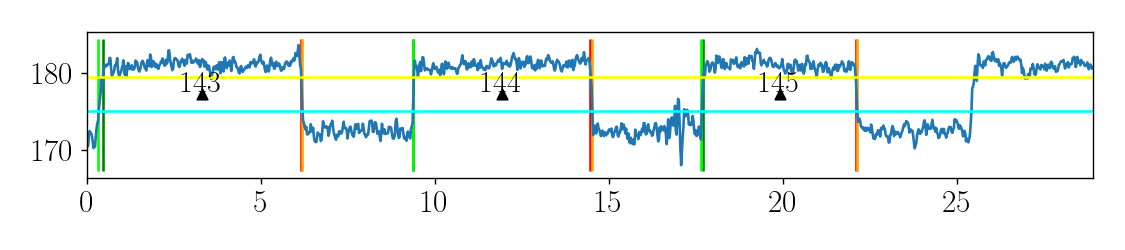

[143, 144, 145]

In [59]:
# reload(plt)
# %matplotlib notebook
idx = 0
drops_in_frame(idx)

3 3
3 3


<IPython.core.display.Javascript object>


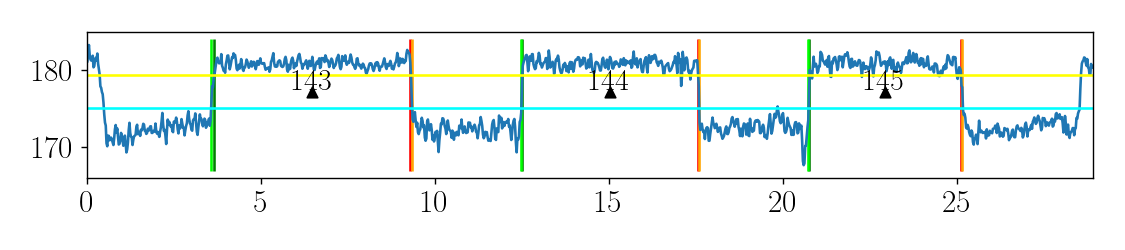

[143, 144, 145]

In [60]:
drops_in_frame(idx + 1)

3 3
3 3


<IPython.core.display.Javascript object>


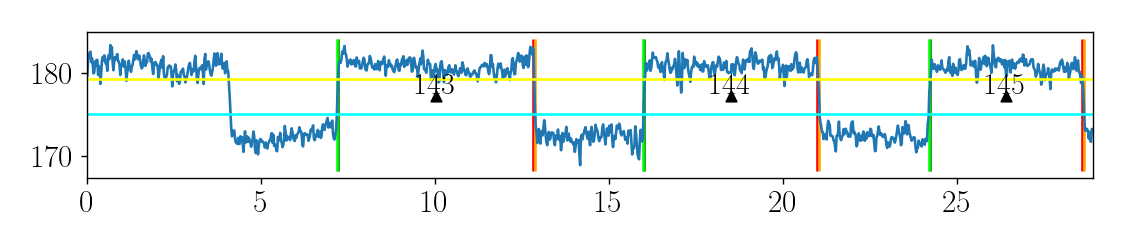

[143, 144, 145]

In [61]:
drops_in_frame(idx + 2)

### Creating dictionary where to save fit parameters

In [62]:
fit_dict = {}

## Distance and wavelenght

In [63]:
drop_distances = []
drop_wavelenghts = []

for i in range(len(droplets) - 1):
    drop_distances.append(np.array([]))
    drop_wavelenghts.append([])

for i,drop_ids in enumerate(reversed(ID_mask)):
    frame_idx = len(ID_mask) - i - 1
    for j,drop_id in enumerate(drop_ids[:-1]):
        edge1 = droplets[drop_id].edges[droplets[drop_id].index(frame_idx)]
        edge2 = droplets[drop_ids[j + 1]].edges[droplets[drop_ids[j + 1]].index(frame_idx)]
        
        drop_wavelenghts[drop_id].append(np.mean(edge2 - edge1))
        drop_distances[drop_id] = np.vstack([*drop_distances[drop_id], edge2[:2] - edge1[::-1][:2]])
        
drop_distances = np.array(drop_distances)
drop_wavelenghts = np.array(drop_wavelenghts)

In [227]:
drop_distances[0]

array([[3.979721404691043+/-0.01834681898973443,
        4.111645668350696+/-0.01736833720943738],
       [3.979721404691043+/-0.01834681898973443,
        4.111645668350696+/-0.01736833720943738],
       [3.935748874728688+/-0.01819179491555172,
        4.111647892941558+/-0.027005905621775135],
       [3.935748874728688+/-0.01824357640923359,
        4.111647892941558+/-0.026835136802714533],
       [3.9357510993195506+/-0.01632171003235522,
        4.045688171085166+/-0.01675629298318341],
       [3.979727707698486+/-0.01583526354128946,
        4.067677216804921+/-0.014872168042154774],
       [3.935755177736132+/-0.01710672111255345,
        4.089667004054964+/-0.02327077591047504],
       [3.935755177736132+/-0.01710672111255345,
        4.089667004054964+/-0.02327077591047504],
       [3.9577449649861745+/-0.017072486346155838,
        4.067681665986645+/-0.016140467718749132],
       [3.9577449649861745+/-0.017072486346155838,
        4.067681665986645+/-0.016140467718749132],


In [208]:
drop_ids

array([  0,   1,   2,   3,   4,   5,   8,   9,  10,  11,  12,  13,  14,
        15,  19,  20,  21,  24,  25,  26,  29,  30,  31,  33,  34,  35,
        38,  39,  40,  45,  46,  48,  49,  50,  53,  54,  56,  57,  58,
        60,  61,  62,  63,  64,  66,  67,  68,  70,  71,  72,  75,  76,
        78,  79,  80,  81,  82,  84,  85,  86,  88,  89,  90,  92,  93,
        94,  95,  96,  98,  99, 100, 101, 102, 103, 104, 106, 107, 111,
       112, 113, 114, 118, 119, 120, 123, 124, 125, 126, 127, 128, 129,
       130, 132, 133, 134, 135, 138, 139, 142, 143, 144, 145, 147, 148,
       149, 150, 151, 152, 153, 156, 158, 159, 160, 161, 162, 164, 165,
       166, 167, 170, 171, 173, 174, 177, 178, 179, 181, 182, 183, 184,
       185, 186, 187, 188, 189, 190, 192, 193, 194, 195, 196, 197, 198,
       199, 200, 201, 202, 203, 204, 206, 207, 208, 210, 211, 212, 213,
       214, 215])

<IPython.core.display.Javascript object>


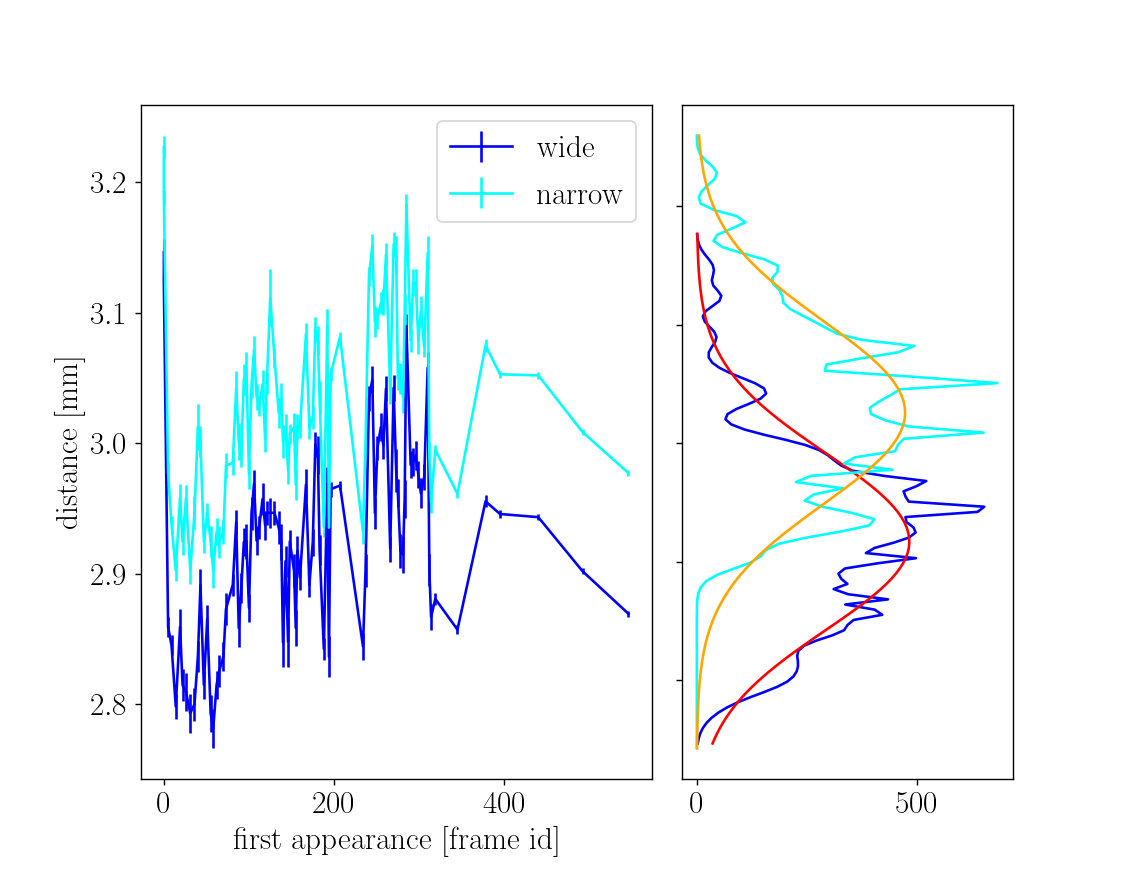

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.64it/s]


<IPython.core.display.Javascript object>


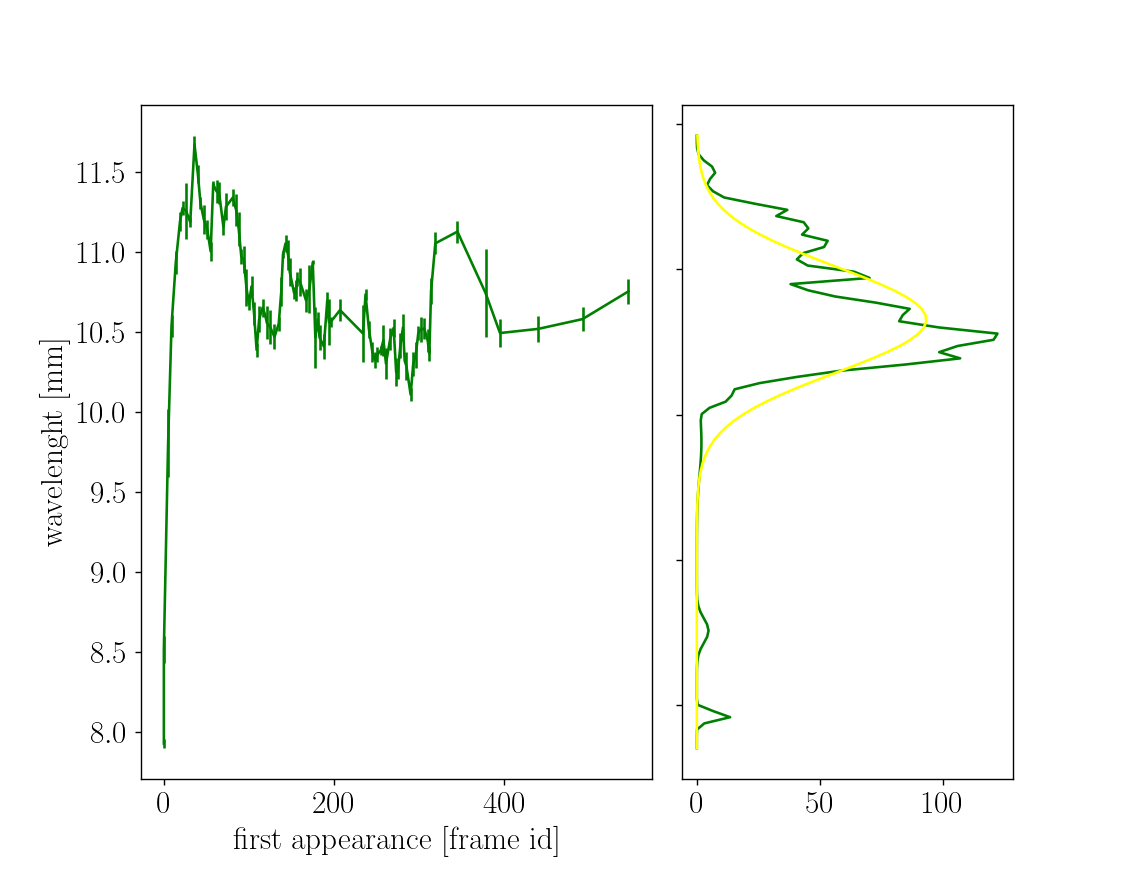

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.73it/s]


fit_params_dw = array([2.916964531755519+/-0.0023494739791535334,
       0.07459519501920209+/-0.002386299576130636], dtype=object)
fit_params_dn = array([3.0257361504449847+/-0.0027188098490984257,
       0.07734550498943737+/-0.0027207253180688714], dtype=object)
fit_params_w = array([10.653387565505819+/-0.017974798200584514,
       0.36441480232793433+/-0.017976081329038687], dtype=object)


In [66]:
subname = 'distance'

min_recurrence = 2

use_mean_error = False

drop_ids = [i for i,d in enumerate(drop_wavelenghts) if len(d) >= min_recurrence]

### use the error of the mean
ws = np.array([np.mean(d) for d in drop_wavelenghts[drop_ids]])
d_w = np.array([np.mean(d[:,0]) for d in drop_distances[drop_ids]])
d_n = np.array([np.mean(d[:,1]) for d in drop_distances[drop_ids]])

if not use_mean_error:
    ### use the std along different frames
    w_stds = np.array([np.std(value(d)) for d in drop_wavelenghts[drop_ids]])
    ws = ufloatify(value(ws), w_stds)


first_appearances = np.array([d.frames[-1] for d in droplets[drop_ids]])


fig, axes, fit_params_dw = uplt.side_hist_plot(first_appearances, d_w, bins=100, figsize=(9,7),
                                         color='blue', fit_color='red', label='wide',
                                         xlabel='first appearance [frame id]', ylabel='distance [mm]')
fig, axes, fit_params_dn = uplt.side_hist_plot(first_appearances, d_n, bins=100, external_axes=axes,
                                         color='cyan', fit_color='orange', label='narrow')

fig.savefig(f'{plot_dir}/{name}_{subname}.png')



subname = 'wavelenght'

fig, axes, fit_params_w = uplt.side_hist_plot(first_appearances, ws, bins=100, figsize=(9,7),
                                         color='green', fit_color='yellow',
                                         xlabel='first appearance [frame id]', ylabel='wavelenght [mm]')

print(f'{fit_params_dw = }')
print(f'{fit_params_dn = }')
print(f'{fit_params_w = }')

#insert in dictionary
fit_dict['distance w [mm]'] = fit_params_dw
fit_dict['distance n [mm]'] = fit_params_dn
fit_dict['wavelenght [mm]'] = fit_params_w

fig.savefig(f'{plot_dir}/{name}_{subname}.png')

## Droplet statistics

In general using the error of the mean yields more noisy kde plots and hence higher error on the fit parameters, however using as error the std along of the droplets along the video is probably an overestimation of the error

### Size

<IPython.core.display.Javascript object>


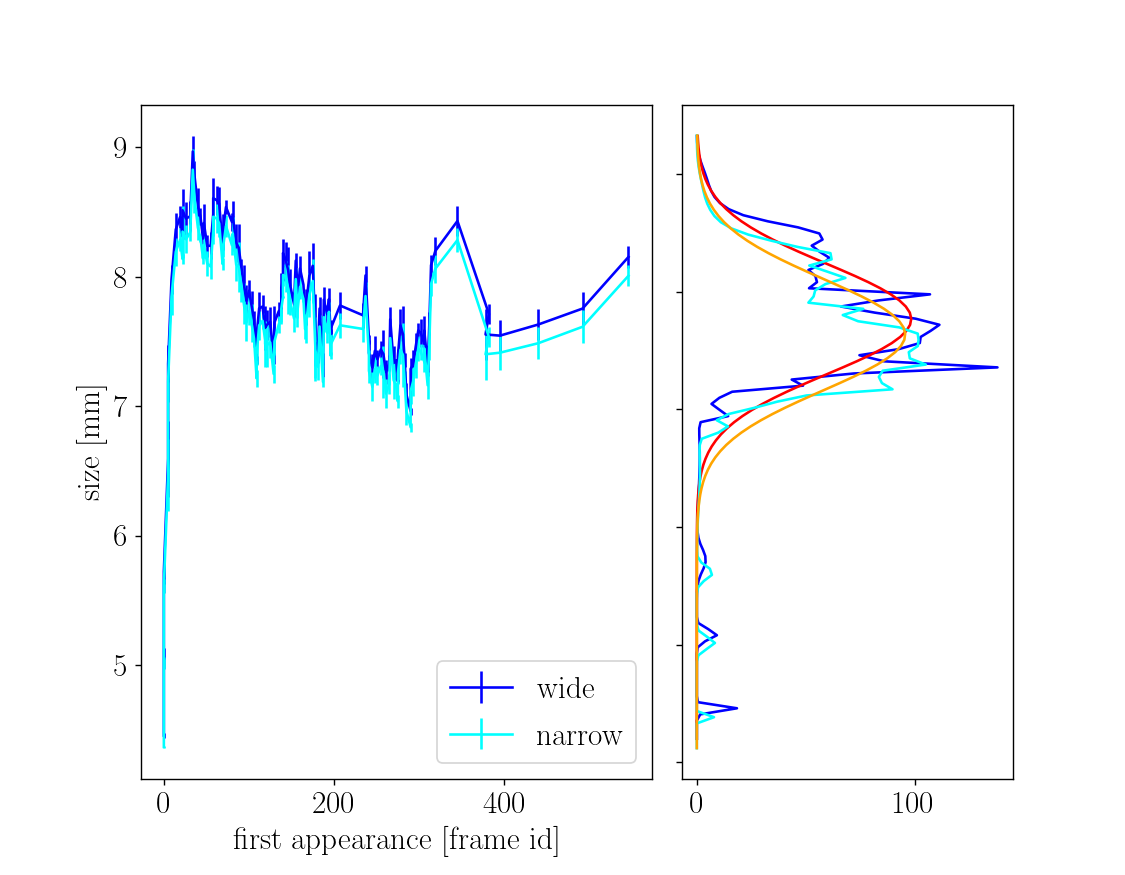

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.58it/s]


fit_params_sw = array([7.767864524981444+/-0.02105212308710819,
       0.46882750082149727+/-0.021054981135644028], dtype=object)
fit_params_sn = array([7.635262322056158+/-0.01706151247468823,
       0.47394467508254357+/-0.01706210182134934], dtype=object)


In [67]:
subname = 'size'

min_recurrence = 2

use_mean_error = False


### use the error of the mean
s_w = np.array([d.size[0][0] for d in droplets if d.recurrence >= min_recurrence])
s_n = np.array([d.size[0][1] for d in droplets if d.recurrence >= min_recurrence])

if not use_mean_error:
    ### use the std along different frames
    size_stds = np.array([d.size[1] for d in droplets if d.recurrence >= min_recurrence])
    s_w = ufloatify(value(s_w), size_stds[:,0])
    s_n = ufloatify(value(s_n), size_stds[:,1])

drop_ids = np.array([d.ID for d in droplets if d.recurrence >= min_recurrence])
first_appearances = np.array([d.frames[-1] for d in droplets if d.recurrence >= min_recurrence])


fig, axes, fit_params_sw = uplt.side_hist_plot(first_appearances, s_w, bins=100, figsize=(9,7),
                                         color='blue', fit_color='red', label='wide',
                                         xlabel='first appearance [frame id]', ylabel='size [mm]')

fig, axes, fit_params_sn = uplt.side_hist_plot(first_appearances, s_n, bins=100, external_axes=axes,
                                         color='cyan', fit_color='orange', label='narrow')

print(f'{fit_params_sw = }')
print(f'{fit_params_sn = }')

#insert in dictionary
fit_dict['size w [mm]'] = fit_params_sw
fit_dict['size n [mm]'] = fit_params_sn


fig.savefig(f'{plot_dir}/{name}_{subname}.png')

## Meniscus size

<IPython.core.display.Javascript object>


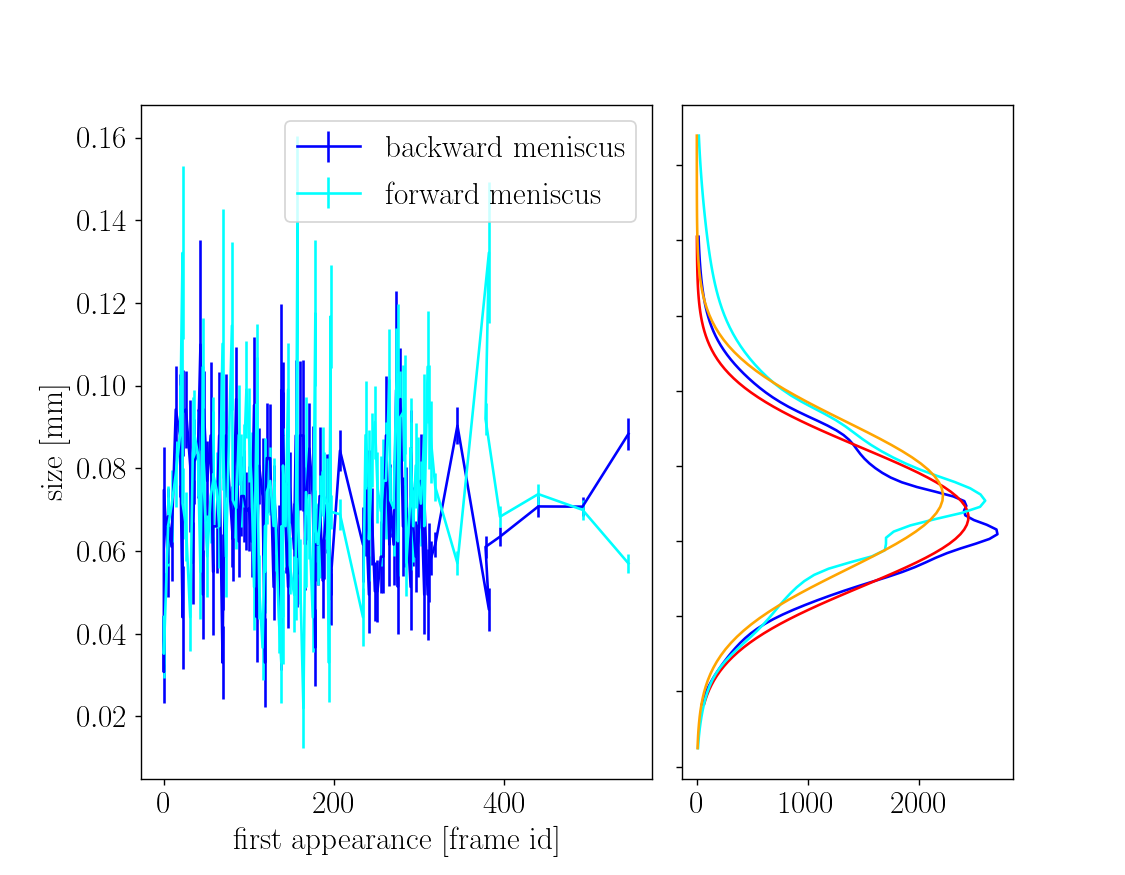

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.39it/s]


fit_params_mb = array([0.06637639749406375+/-0.00027347779407511653,
       0.018476435200237118+/-0.0002743381054079134], dtype=object)
fit_params_mf = array([0.07207753616516176+/-0.00032548017343862664,
       0.019696808938726162+/-0.00032550599662715127], dtype=object)


In [68]:
subname = 'meniscus_size'

min_recurrence = 2

use_mean_error = True


m_b = np.array([d.menisc_size[0][0] for d in droplets if d.recurrence >= min_recurrence])
m_f = np.array([d.menisc_size[0][1] for d in droplets if d.recurrence >= min_recurrence])

if not use_mean_error:
    ### use the std along different frames
    menisc_size_stds = np.array([d.menisc_size[1] for d in droplets if d.recurrence >= min_recurrence])
    m_b = ufloatify(value(m_b), menisc_size_stds[:,0])
    m_f = ufloatify(value(m_f), menisc_size_stds[:,1])

drop_ids = np.array([d.ID for d in droplets if d.recurrence >= min_recurrence])
first_appearances = np.array([d.frames[-1] for d in droplets if d.recurrence >= min_recurrence])


fig, axes, fit_params_mb = uplt.side_hist_plot(first_appearances, m_b, bins=100, figsize=(9,7),
                                         color='blue', fit_color='red', label='backward meniscus',
                                         xlabel='first appearance [frame id]', ylabel='size [mm]')

fig, axes, fit_params_mf = uplt.side_hist_plot(first_appearances, m_f, bins=100, figsize=(9,7), external_axes=axes,
                                         color='cyan', fit_color='orange', label='forward meniscus')

print(f'{fit_params_mb = }')
print(f'{fit_params_mf = }')

fit_dict['meniscus size b [mm]'] = fit_params_mb
fit_dict['meniscus size f [mm]'] = fit_params_mf

fig.savefig(f'{plot_dir}/{name}_{subname}.png')

## Velocity

<IPython.core.display.Javascript object>


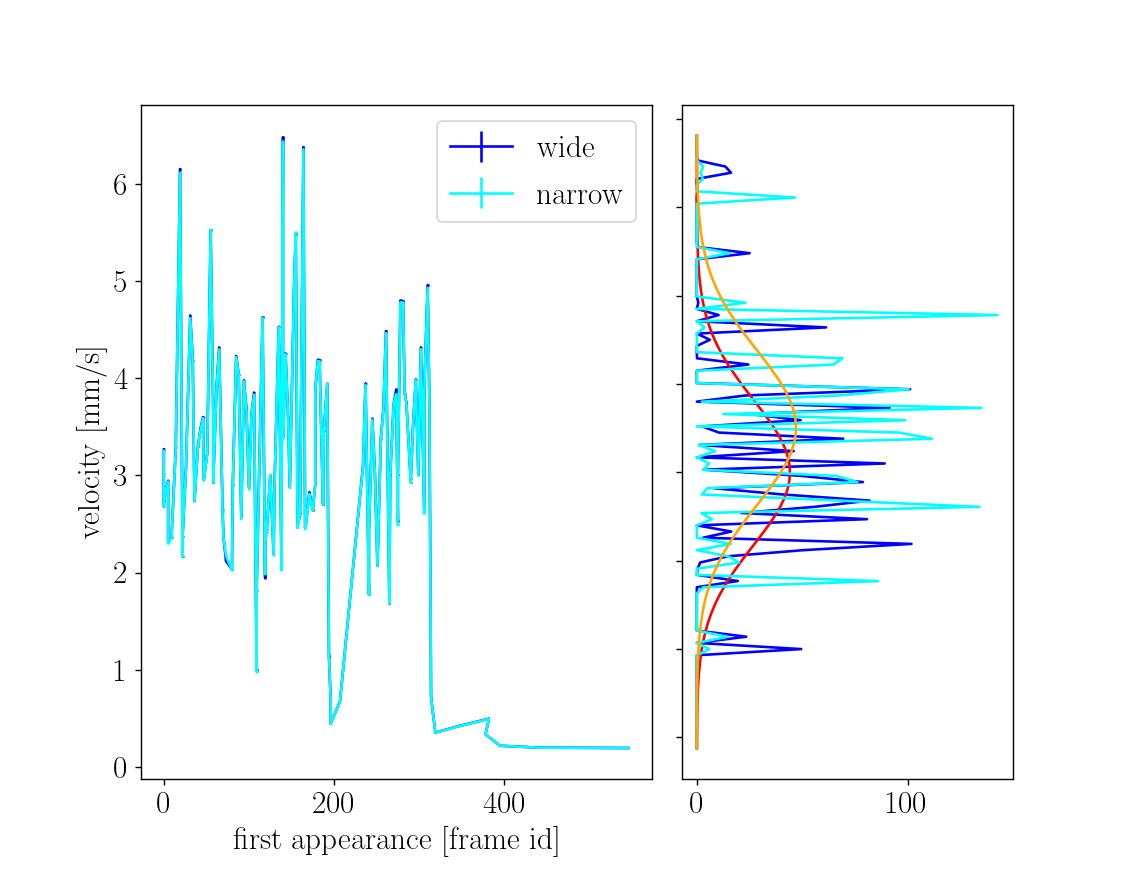

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.85it/s]


fit_params_vw = array([2.998909454446872+/-0.12602979020207997,
       0.8262166041921855+/-0.12603254362366095], dtype=object)
fit_params_vn = array([3.50556226025245+/-0.16966704453215314,
       0.8764966271049068+/-0.16967929961262254], dtype=object)


In [69]:
subname = 'velocity'

use_mean_error = True

# at least 2 otherwise cannot compute velocity
min_recurrence = 2

v_w = np.array([d.velocity[0][0] for d in droplets if d.recurrence >= min_recurrence])
v_n = np.array([d.velocity[0][1] for d in droplets if d.recurrence >= min_recurrence])

if not use_mean_error:
    velocity_stds = np.array([d.velocity[1] for d in droplets if d.recurrence >= min_recurrence])
    v_w = ufloatify(value(v_w), velocity_stds[:,0])
    v_n = ufloatify(value(v_n), velocity_stds[:,1])

drop_ids = np.array([d.ID for d in droplets if d.recurrence >= min_recurrence])
first_appearances = np.array([d.frames[-1] for d in droplets if d.recurrence >= min_recurrence])


fig, axes, fit_params_vw = uplt.side_hist_plot(first_appearances, v_w, bins=100, figsize=(9,7),
                                         color='blue', fit_color='red', label='wide',
                                         xlabel='first appearance [frame id]', ylabel='velocity [mm/s]')

fig, axes, fit_params_vn = uplt.side_hist_plot(first_appearances, v_n, bins=100, figsize=(9,7), external_axes=axes,
                                         color='cyan', fit_color='orange', label='narrow')

print(f'{fit_params_vw = }')
print(f'{fit_params_vn = }')

fit_dict['velocity w [mm/s]'] = fit_params_vw
fit_dict['velocity n [mm/s]'] = fit_params_vn

fig.savefig(f'{plot_dir}/{name}_{subname}.png')

<IPython.core.display.Javascript object>


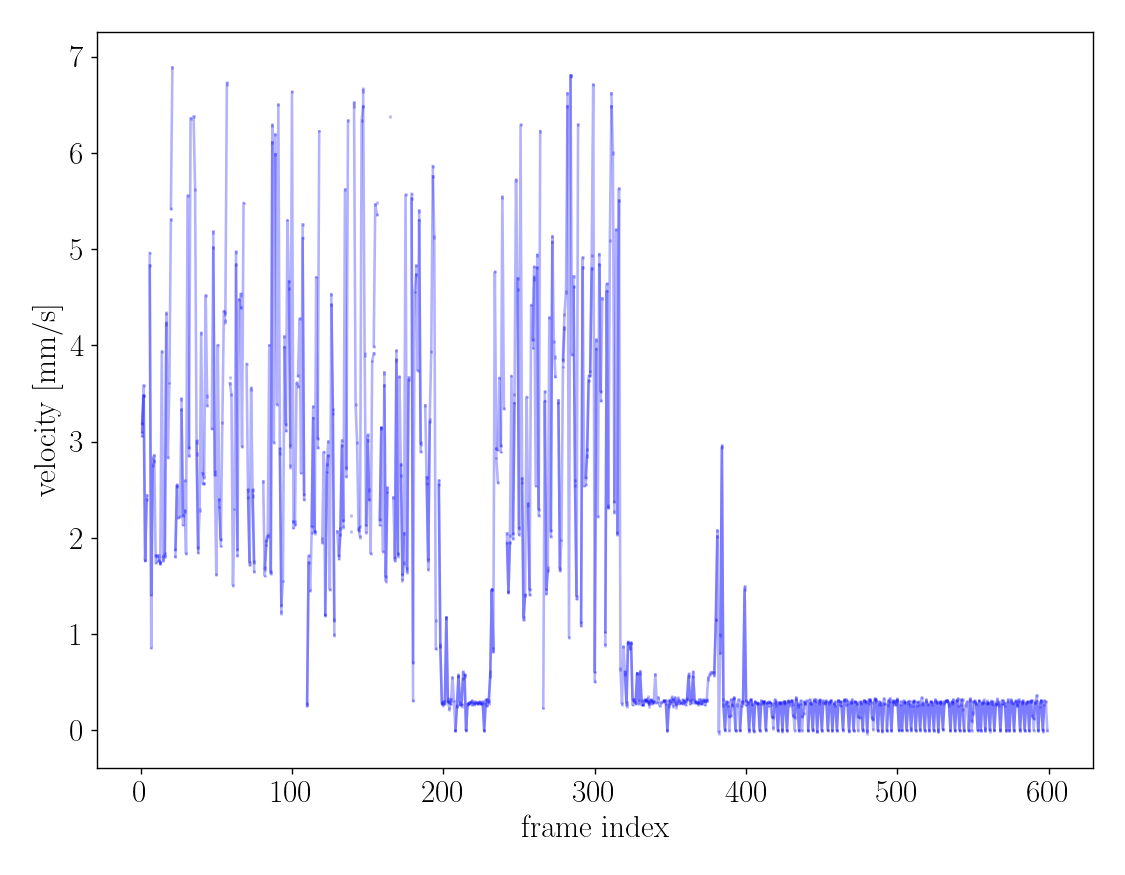

In [70]:
# velocity - frame_id correlation identifying droplets

subname = 'v_vs_frame_id'


fig,ax = plt.subplots(figsize=(9,7))
for d in droplets:
    if d.recurrence >= min_recurrence:
        uplt.plot(d.frames[:-1], d.velocities[:,0], color='blue', alpha=0.3)
#         uplt.plot(d.frames[:-1], d.velocities[:,1], color='cyan', alpha=0.3)
    
plt.xlabel('frame index')
plt.ylabel('velocity [mm/s]')

fig.tight_layout()

fig.savefig(f'{plot_dir}/{name}_{subname}.png')

## Save fit results to csv

In [266]:
fit_dict

{'distance w [mm]': array([3.9862424942604133+/-0.0058141862702354675,
        0.09594357940120846+/-0.005815212089376568], dtype=object),
 'distance n [mm]': array([4.1294051404516905+/-0.003751689460258624,
        0.09941219161498505+/-0.003751722668420332], dtype=object),
 'wavelenght [mm]': array([8.550290749621004+/-0.0034773383429454836,
        0.1592495900735471+/-0.003478081060123495], dtype=object),
 'size w [mm]': array([4.5683425896262175+/-0.0041794743517175464,
        0.22456066007942432+/-0.004179867599181976], dtype=object),
 'size n [mm]': array([4.3870519535386014+/-0.004798443249644996,
        0.23870859032591252+/-0.0047984397063648996], dtype=object),
 'menisc size b [mm]': array([0.08762139671807076+/-0.0003721378890799895,
        0.01838106856576327+/-0.0003721713493438903], dtype=object),
 'menisc size f [mm]': array([0.07637625807349831+/-0.0003798030933636176,
        0.01874397196975397+/-0.00038005314546406705], dtype=object),
 'velocity w [mm/s]': array

In [71]:
fit_df = pd.DataFrame(data=[], columns=['property', 'mean', 'mean std', 'sigma', 'sigma std'])
for k,a in fit_dict.items():
    fit_df.loc[len(fit_df)] = [k, a[0].n, a[0].s, a[1].n, a[1].s]

In [72]:
def safe_save(method, filename, **kwargs):    
    while(os.path.exists(filename)):
        o = input(f'{filename} already exists: overwrite? [y/n] ')
        if o == 'y':
            break
        o = input('Would you like to save with another name? [y/n]')
        if o != 'y':
            return
        filename = input('Type filename: ')
            
    return method(filename, **kwargs)

In [73]:
subname = 'fits'

save_path = f'{plot_dir}/{name}_{subname}.csv'

safe_save(fit_df.to_csv, filename=save_path, index=False)

## All correlation plots

#### testing

In [74]:
df = pd.DataFrame(data=[], columns=['c1', 'c2', 'c3'])
for i in range(100):
    df.loc[len(df)] = list(np.random.uniform(0,1,3))

In [121]:
df.corr()

c1        c2        c3
c1  1.000000  0.112297  0.155077
c2  0.112297  1.000000  0.132037
c3  0.155077  0.132037  1.000000

In [75]:
def correlation_plots(df, bins=20, **kwargs):
    fontsize = kwargs.pop('fontsize', None)
    figsize = kwargs.pop('figsize', (9,9))
    
    v_df = df.copy()
    for key in v_df.keys():
        if type(v_df[key][0]) in [unc.core.Variable, unc.core.AffineScalarFunc]:
            v_df[key] = value(v_df[key])
        else:
            v_df[key] = np.array(v_df[key], dtype=float)
    
    cols = df.columns
    fig, axs = plt.subplots(len(cols), len(cols), figsize=figsize)
    for i,l1 in enumerate(cols):
        for j,l2 in enumerate(cols):
            if i == j:
                if type(df[l1][0]) in [unc.core.Variable, unc.core.AffineScalarFunc]:
                    kernel = uplt.ExtendedKDE(df[l1])
                    kernel.plot(bins, ax=axs[i,j])
                else:
                    axs[i,j].hist(df[l1], bins=bins)
                axs[i,j].grid(axis='x')
            elif i > j:
                uplt.plot(df[l2],df[l1], ax=axs[i,j], **kwargs)
                axs[i,j].grid(axis='both')
            else:
                c = v_df.corr()[l1][l2]
#                 axs[i,j].set_facecolor(f'{0.5*(c + 1)}')
                axs[i,j].set_facecolor(matplotlib.cm.coolwarm(0.5*(c + 1)))
                axs[i,j].text(0.5, 0.5, f'{c:.4f}', fontsize=16, ha='center', va='center')
                axs[i,j].axis([0,1,0,1])
                axs[i,j].get_xaxis().set_ticks([])
                axs[i,j].get_yaxis().set_ticks([])
                
            if i < len(cols) - 1:
                axs[i,j].get_xaxis().set_ticklabels([])
            else:
                axs[i,j].tick_params(axis='x', labelsize=fontsize)
            if i != j and j > 0:
                axs[i,j].get_yaxis().set_ticklabels([])
            else:
                axs[i,j].tick_params(axis='y', labelsize=fontsize)
                
            if i == 0:
                axs[i,j].set_xlabel(l2, fontsize=fontsize)
                axs[i,j].xaxis.set_label_position('top')
            if j == len(cols) - 1:
                axs[i,j].set_ylabel(l1, fontsize=fontsize)
                axs[i,j].yaxis.set_label_position('right')
    
    fig.tight_layout()
                
    return fig,axs

### Applying it to the drops

In [76]:
cols = ['first appearance', 'recurrence', 'size w [mm]',
        'b m size [mm]', 'v [mm/s]']

df = pd.DataFrame(data=[], columns=cols)

min_recurrence = 2

for d in droplets:
    if d.recurrence >= min_recurrence:
        df.loc[len(df)] = [d.frames[-1], d.recurrence, d.size[0][0], d.menisc_size[0][0], d.velocity[0][0]]

<IPython.core.display.Javascript object>


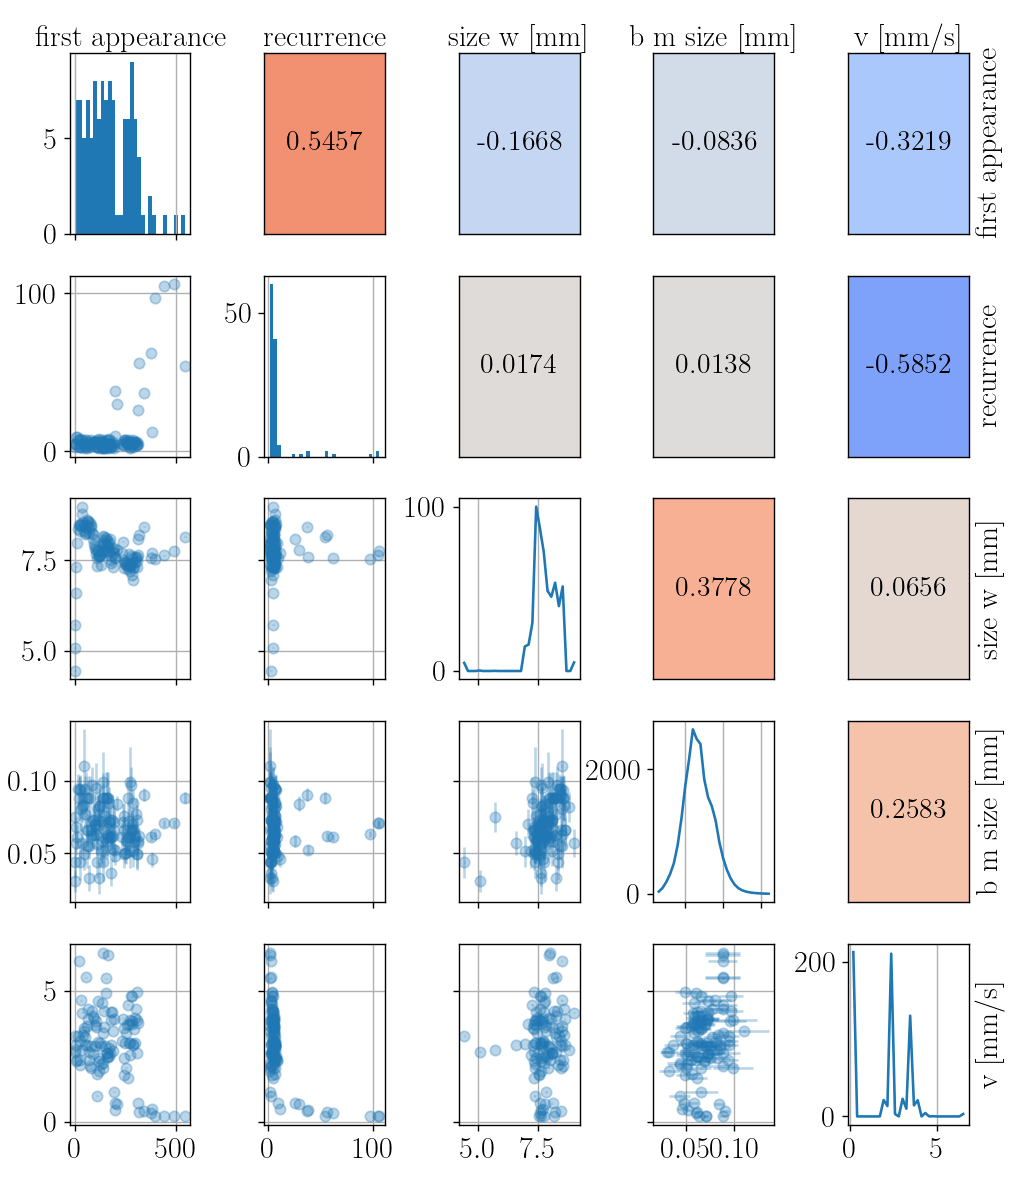

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.91it/s]


In [78]:
subname = 'correlations'

fig,axs = correlation_plots(df, bins=30, alpha=0.3, fmt='o', figsize=(11,11))


fig.savefig(f'{plot_dir}/{name}_{subname}.png')